<a href="https://colab.research.google.com/github/khanandaap/Tugas-Akhir/blob/main/TugasAkhir_HoltWinters_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
!pip install libarchive
!pip install Graphviz
!pip install matplotlib-venn
!pip install tensorflow_addons

  Using cached libarchive-0.4.7.tar.gz (23 kB)
  Preparing metadata (setup.py) ... done
  Using cached nose-1.3.7-py3-none-any.whl (154 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for libarchive
  Running setup.py clean for libarchive
Failed to build libarchive
ERROR: Could not build wheels for libarchive, which is required to install pyproject.toml-based projects


In [ ]:
# Library
import os
import random
import time
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from itertools import product

# Graphics
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']= 10, 4
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import pydot
import pydotplus

# Statistics
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW

from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import check_random_state
from keras import optimizers

warnings.filterwarnings("ignore")

In [ ]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    check_random_state(seed)

# Prepare Dataset

In [ ]:
df = pd.read_csv('TLKM.JK.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1232 non-null   object 
 1   Price   1231 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.4+ KB


In [ ]:
print(df.columns)

Index(['Date', 'Price'], dtype='object')


In [ ]:
df.describe().style.set_properties(**{'font-family': 'Segoe UI'})

## KMI

In [ ]:
def KMI(dataset, columns):
  # Identify the outliers in each columns
  for i in columns:
    # Replace outliers with the maximum values of each columns
    dataset.loc[dataset[i].isnull() == True, i] = dataset[i].mean()

  # Return the new DataFrame
  return dataset

# Replace the outliers
df = KMI(df, ['Price'])

In [ ]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', drop = True, inplace = True)
# df.drop('No', axis = 1, inplace = True)
df.head(10)

Price
Date                   
2019-01-01  3102.091309
2019-01-02  3085.546875
2019-01-03  3093.818848
2019-01-04  3069.002197
2019-01-07  3118.635742
2019-01-08  3143.452148
2019-01-09  3085.546875
2019-01-10  3143.452148
2019-01-11  3193.085938
2019-01-14  3184.813721

## Plot Data

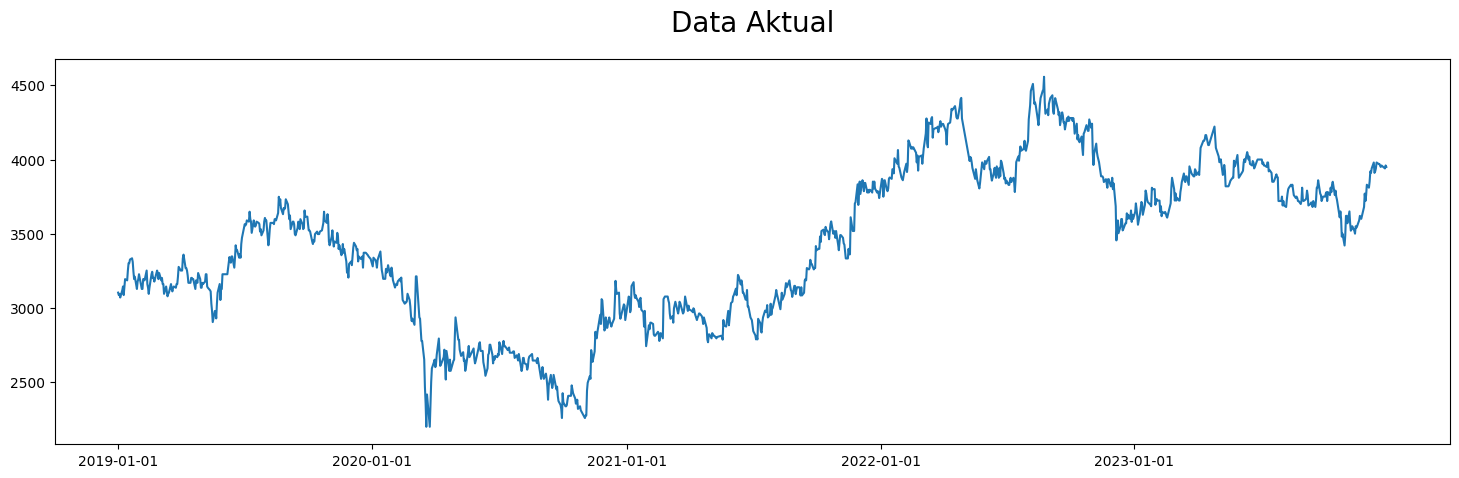

In [ ]:
# Grafik Data Aktual

plt.figure(figsize = (18,5))
plt.plot(df)
xticks = pd.date_range(datetime.datetime(2019,1,1), datetime.datetime(2023,12,31), freq='YS')
plt.xticks([x.strftime('%Y') for x in xticks])
plt.title("Data Aktual", fontsize=20, pad = 20)
plt.show()

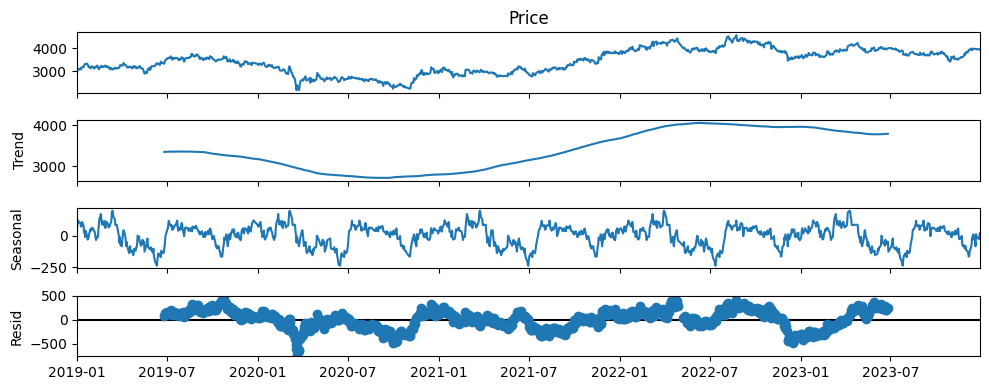

In [ ]:
result = seasonal_decompose(df['Price'], model='additive', period=252)  # period disesuaikan dengan data Anda

# Plot hasil dekomposisi
result.plot()
plt.show()


## K-Fold Validation

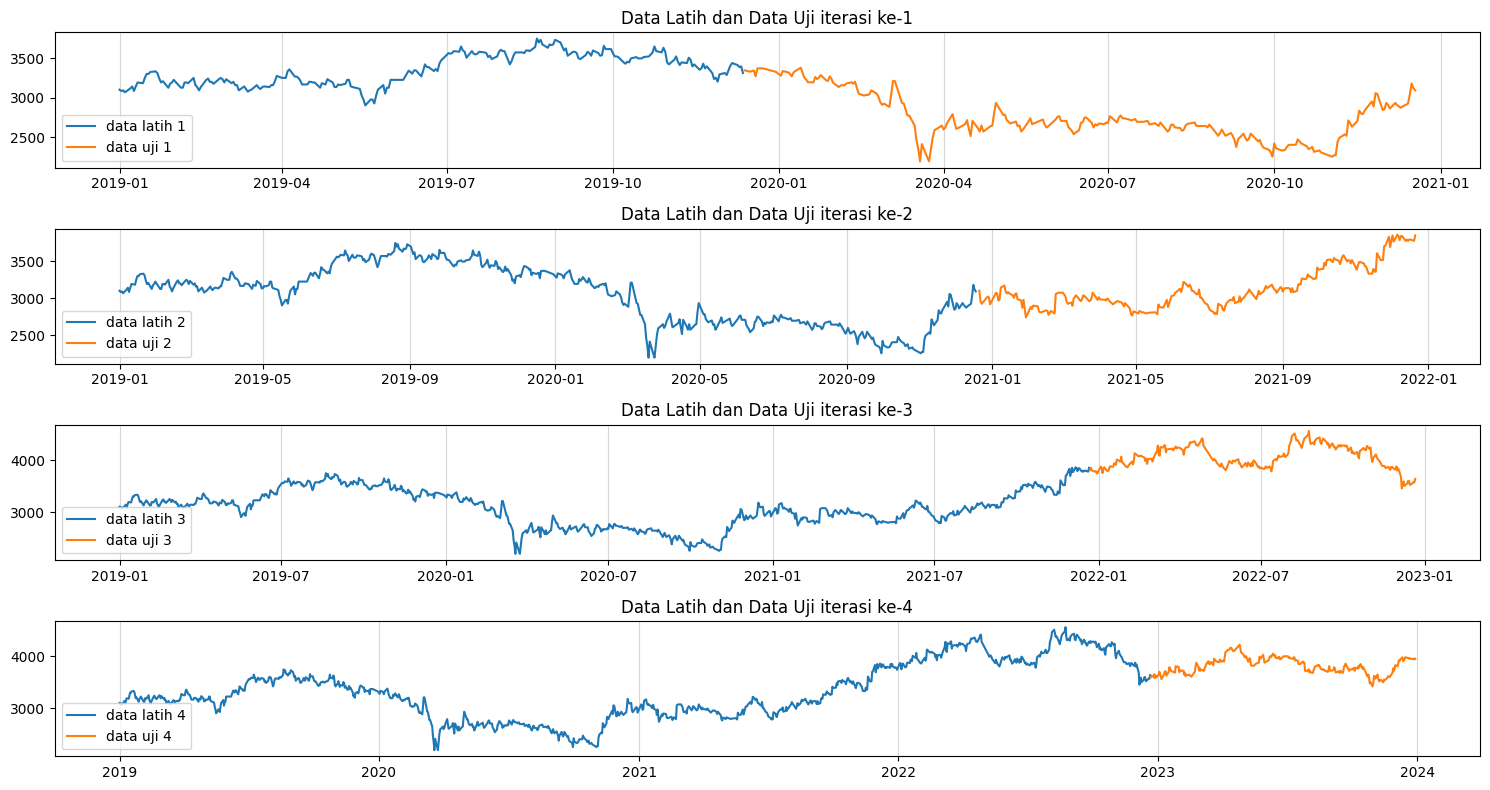

In [ ]:
# Mempartisi data test dan data train dengan kfold validation

n_splits = 4

tscv = TimeSeriesSplit(gap = 0,
                       n_splits = n_splits,
                       max_train_size = None)

df_train, df_test = [], []

fig, ax = plt.subplots(nrows = n_splits,
                       ncols = 1,
                       figsize = (15, 8))

for i, (train_index, test_index) in enumerate(tscv.split(df['Price'])):

  # Implementasi Cross Validation
  df_train.append(df.iloc[train_index])
  df_test.append(df.iloc[test_index])

  # Subplot hasil cross validation

  ax[i].plot(df.iloc[train_index], label = f"data latih {i+1}")
  ax[i].plot(df.iloc[test_index], label = f"data uji {i+1}")
  ax[i].set_title(f"Data Latih dan Data Uji iterasi ke-{i+1}", fontsize = 12)
  ax[i].legend(loc = 'lower left')
  ax[i].grid(alpha = 0.5, axis = 'x')

plt.tight_layout()

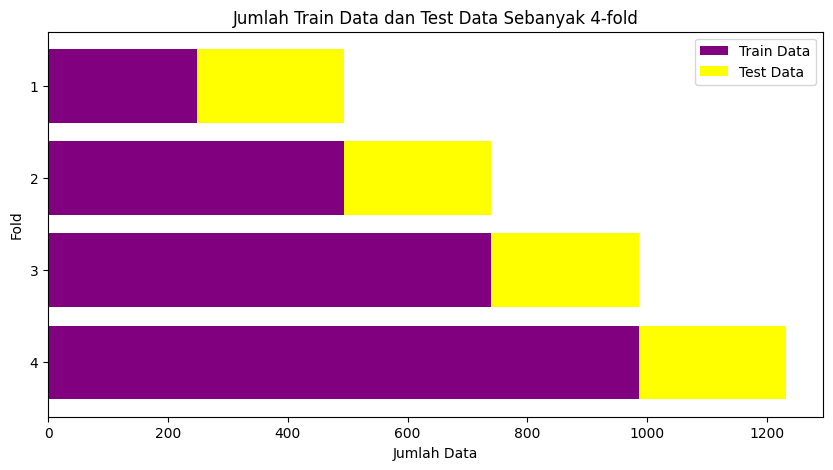

In [ ]:
# Initialize lists to store number of samples in each fold for train and test set
train_fold_sizes = []
test_fold_sizes = []

# Loop through each fold and store the number of samples in the train and test sets
for train_index, test_index in tscv.split(df['Price']):
    train_fold_sizes.append(len(train_index))
    test_fold_sizes.append(len(test_index))

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(y=np.arange(1, 5), width=train_fold_sizes, color='purple', label='Train Data')
ax.barh(y=np.arange(1, 5), width=test_fold_sizes, color='yellow', left=train_fold_sizes, label='Test Data')
ax.set_title('Jumlah Train Data dan Test Data Sebanyak 4-fold')
ax.set_xlabel('Jumlah Data')
ax.set_ylabel('Fold')
ax.invert_yaxis()
ax.legend()
plt.yticks(np.arange(1, 5, step=1))
plt.show()

## Data Normalize


In [ ]:
df_train[0]

Price
Date                   
2019-01-01  3102.091309
2019-01-02  3085.546875
2019-01-03  3093.818848
2019-01-04  3069.002197
2019-01-07  3118.635742
...                 ...
2019-12-06  3438.325684
2019-12-09  3413.167236
2019-12-10  3388.008789
2019-12-11  3396.395020
2019-12-12  3312.533203

[248 rows x 1 columns]

In [ ]:
# Data Train Scaling
df_train_scaler, df_train_scaled = [], []

for train in df_train:

  # Implementasi Scaler
  temp_scaler_train = MinMaxScaler(feature_range = (0, 1))
  temp_scaled_df_train = temp_scaler_train.fit_transform(train)
  temp_scaled_df_train = pd.DataFrame(temp_scaled_df_train)

  # Reindex and Rename Column
  temp_scaled_df_train.set_index(train.index, inplace = True)
  temp_scaled_df_train.rename(columns = {0:'Price'}, inplace = True)

  # Menyimpan scaler dan data hasil scaling
  df_train_scaler.append(temp_scaler_train)
  df_train_scaled.append(temp_scaled_df_train)

# Data Test Scaling
df_test_scaler, df_test_scaled = [], []

for test in df_test:

  # Implementasi Scaler
  temp_scaler_test = MinMaxScaler(feature_range = (0, 1))
  temp_scaled_df_test = temp_scaler_test.fit_transform(test)
  temp_scaled_df_test = pd.DataFrame(temp_scaled_df_test)

  # Reindex and Rename Column
  temp_scaled_df_test.set_index(test.index, inplace = True)
  temp_scaled_df_test.rename(columns = {0:'Price'}, inplace = True)

  # Menyimpan scaler dan data hasil scaling
  df_test_scaler.append(temp_scaler_test)
  df_test_scaled.append(temp_scaled_df_test)

In [ ]:
for i in range(1,5):
  df_train_scaled[i-1].to_excel(f'Normalisasi Data Train {i}.xlsx')
  df_test_scaled[i-1].to_excel(f'Normalisasi Data Test {i}.xlsx')

# Holt-Winters Exponential Smoothing


## Build Model

In [ ]:
# Inisialisasi Level, Trend, dan Seasonal

seasonal_periods = 5

hwmodel = ExponentialSmoothing(train['Price'],
                               trend = 'add',
                               seasonal = 'add',
                               seasonal_periods = seasonal_periods)
fit_model = hwmodel.fit()

# Mendapatkan nilai inisialisasi
initial_level = fit_model.level[0]
initial_trend = fit_model.trend[0]
initial_seasonal = fit_model.fittedvalues[0:seasonal_periods].values

print("Initial Level:", initial_level)
print("Initial Trend:", initial_trend)
print("Initial Seasonal:", initial_seasonal)

Initial Level: 3093.914951868196
Initial Trend: 16.87892190274555
Initial Seasonal: [3068.79647312 3108.93636522 3103.02476794 3113.42838141 3090.54526951]


## Find Best Parameters

In [ ]:
# Tentukan kumpulan nilai parameter yang akan diuji

alphas = [float(i) / 10 for i in range(1, 4)]
betas = [float(i) / 10 for i in range(1, 4)]
gammas = [float(i) / 10 for i in range(1, 4)]

best_mse = float('inf')
best_params = (0, 0, 0)

# Looping melalui kombinasi nilai parameter

for i, (train, test) in enumerate(zip(df_train_scaled, df_test_scaled)):
  for alpha in alphas:
    for beta in betas:
      for gamma in gammas:

        model = ExponentialSmoothing(train.iloc[:,0],
                                     seasonal = 'add',
                                     seasonal_periods = 5,
                                     trend = 'add')

        fit_model = model.fit(smoothing_level = alpha,
                              smoothing_slope = beta,
                              smoothing_seasonal = gamma)

        y_pred = fit_model.forecast(len(test))
        mse = mean_squared_error(test.iloc[:,0], y_pred)

        # Perbarui parameter terbaik jika ditemukan yang lebih baik
        if mse < best_mse:
          best_mse = mse
          best_params = (alpha, beta, gamma)

  print(f"Best Parameters di partisi ke-{i} (alpha, beta, gamma): {best_params}")

Best Parameters di partisi ke-0 (alpha, beta, gamma): (0.2, 0.1, 0.3)
Best Parameters di partisi ke-1 (alpha, beta, gamma): (0.2, 0.1, 0.3)
Best Parameters di partisi ke-2 (alpha, beta, gamma): (0.2, 0.1, 0.3)
Best Parameters di partisi ke-3 (alpha, beta, gamma): (0.3, 0.2, 0.3)


## Forecast

In [ ]:
# Model Fitting dan Peramalan

forecast_data, forecast_train, forecast_test = [], [], []

zipped_list = zip(df_train, df_test, df_train_scaled, df_test_scaled, df_train_scaler, df_test_scaler)

for train, test, train_scaled, test_scaled, train_scaler, test_scaler in zipped_list:
  # Bangun model
  model = ExponentialSmoothing(train_scaled['Price'],
                               seasonal = 'add',
                               seasonal_periods = 5)

  # Fitting Model
  model_fit = model.fit(0.2, 0.1, 0.3)

  # Prediksi data train dan test
  predict_train = model_fit.predict(start = train_scaled.index[0],
                                    end = train_scaled.index[-1])

  predict_test = model_fit.predict(start = len(train_scaled),
                                   end = len(train_scaled) + len(test_scaled) - 1)

  predict_train = pd.DataFrame(predict_train)
  predict_test = pd.DataFrame(predict_test)

  # Denormalisasi data
  predict_train = train_scaler.inverse_transform(predict_train)
  predict_test = test_scaler.inverse_transform(predict_test)

  # Membuat dataframe gabungan aktual
  predict_train = pd.DataFrame(predict_train,
                               index = train.iloc[:].index)
  predict_train.rename(columns = {0:'predict'}, inplace = True)
  predict_train['actual'] = train['Price'].values

  predict_test = pd.DataFrame(predict_test,
                              index = test.iloc[:].index)
  predict_test.rename(columns = {0:'predict'}, inplace = True)
  predict_test['actual'] = test['Price'].values

  # Menggabungkan hasil prediksi
  df_predict_holtwinter = pd.concat([predict_train, predict_test])

  temp_df = pd.concat([train, test])

  df_predict_holtwinter.rename(columns = {0:'predicted'}, inplace = True)
  temp_df.rename(columns = {0:'Price'}, inplace = True)

  df_predict_holtwinter['actual'] = temp_df['Price'].values

  forecast_data.append(df_predict_holtwinter)
  forecast_train.append(predict_train)
  forecast_test.append(predict_test)

In [ ]:
predict_train

predict       actual
Date                                
2019-01-01  3114.263996  3102.091309
2019-01-02  3091.266181  3085.546875
2019-01-03  3096.460715  3093.818848
2019-01-04  3097.292488  3069.002197
2019-01-07  3094.866576  3118.635742
...                 ...          ...
2022-12-15  3607.378387  3521.786133
2022-12-16  3584.249731  3531.382324
2022-12-19  3563.696670  3569.766846
2022-12-20  3537.783862  3569.766846
2022-12-21  3571.499567  3636.939941

[986 rows x 2 columns]

In [ ]:
predict_train.to_excel('Prediksi Data Train.xlsx')
predict_test.to_excel('Prediksi Data Test.xlsx')
df_predict_holtwinter.to_excel('Prediksi Data Keseluruhan.xlsx')

### Forecast Plot

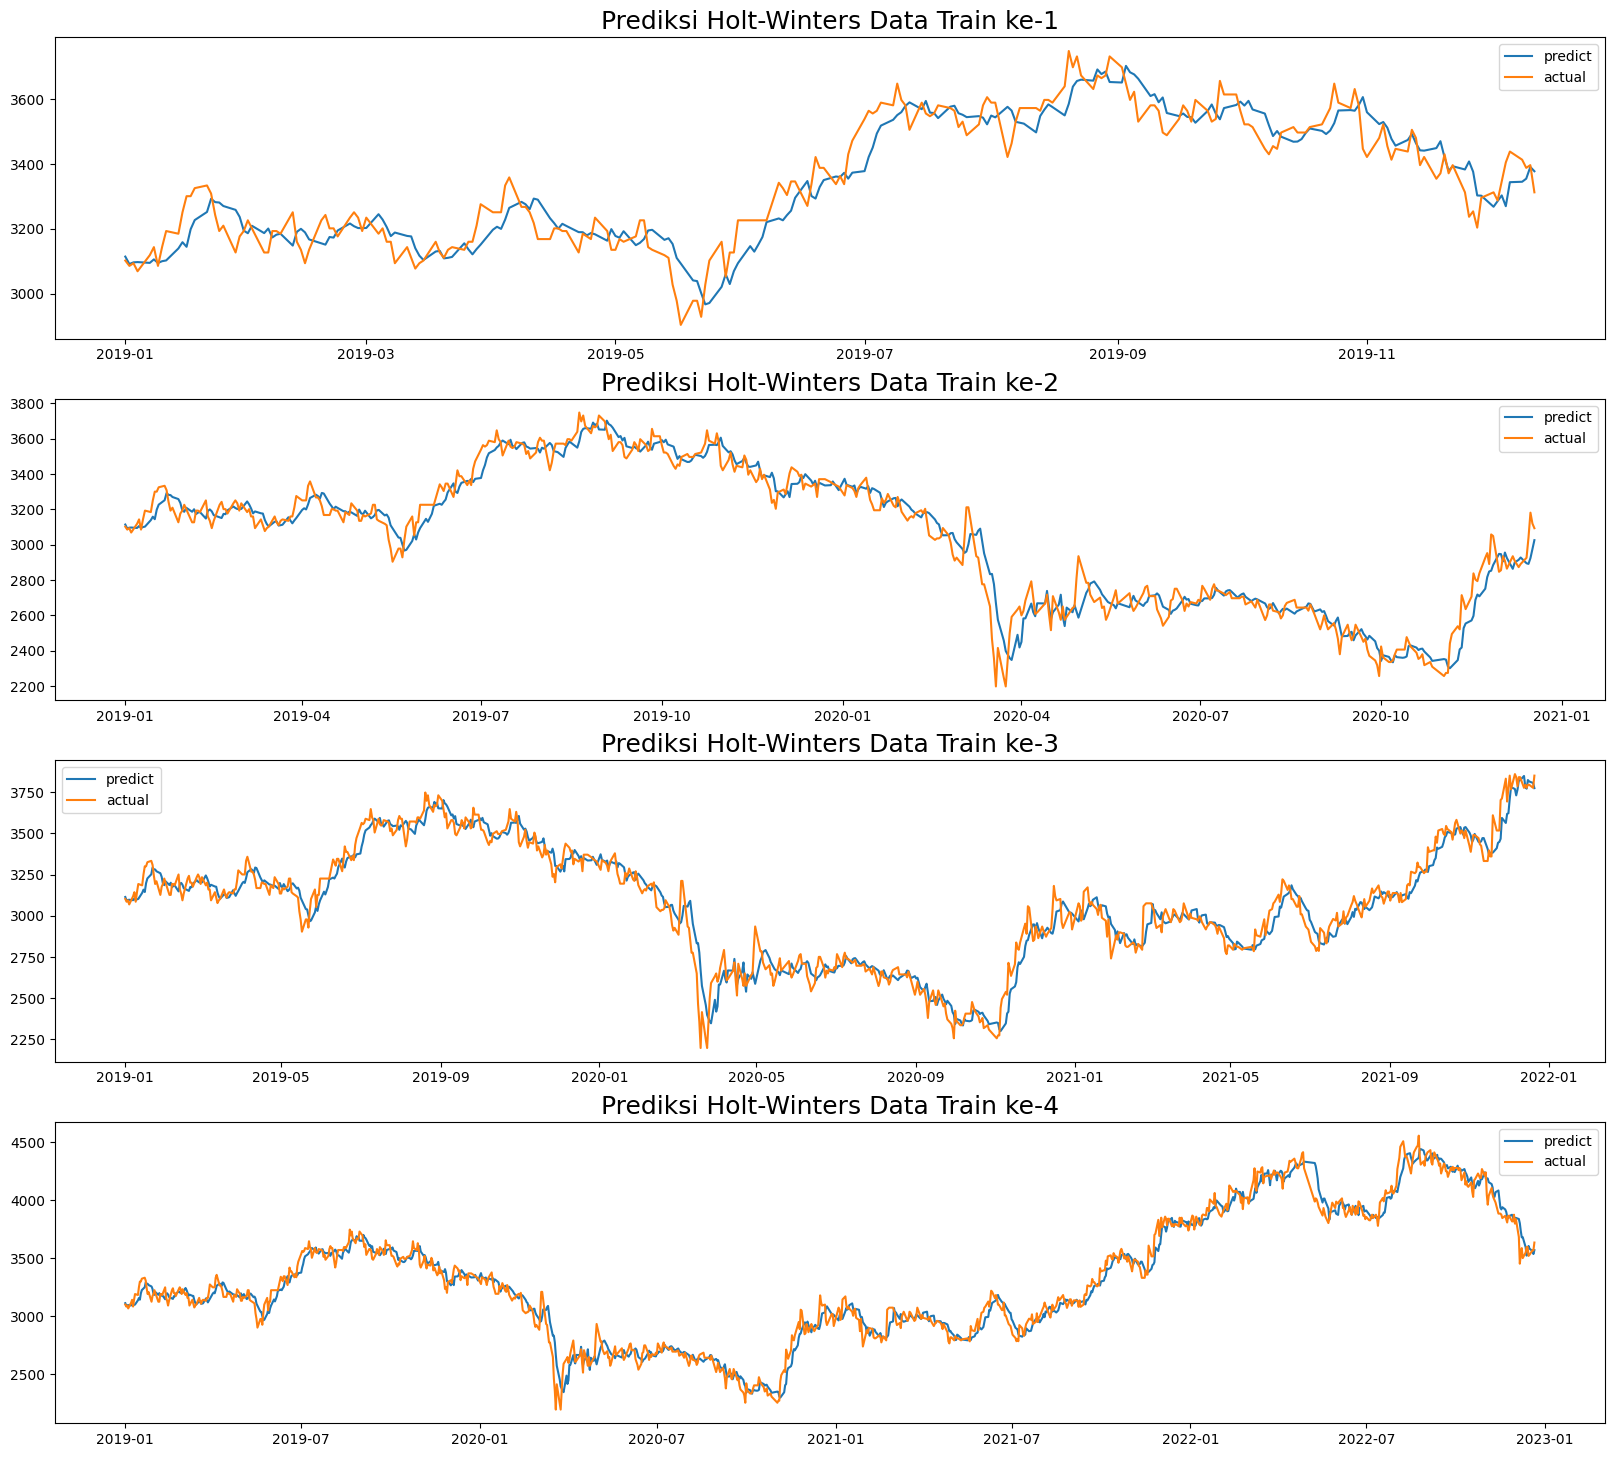

In [ ]:
# Plot Predict Train

fig, axs = plt.subplots(nrows = 4,
                        ncols = 1,
                        figsize = (20, 18))

for i, forec_train in enumerate(forecast_train):
  axs[i].plot(forec_train['predict'], label = 'predict')
  axs[i].plot(forec_train['actual'], label = 'actual')
  axs[i].set_title(f"Prediksi Holt-Winters Data Train ke-{i+1}",
                   fontsize = 18)
  axs[i].legend()

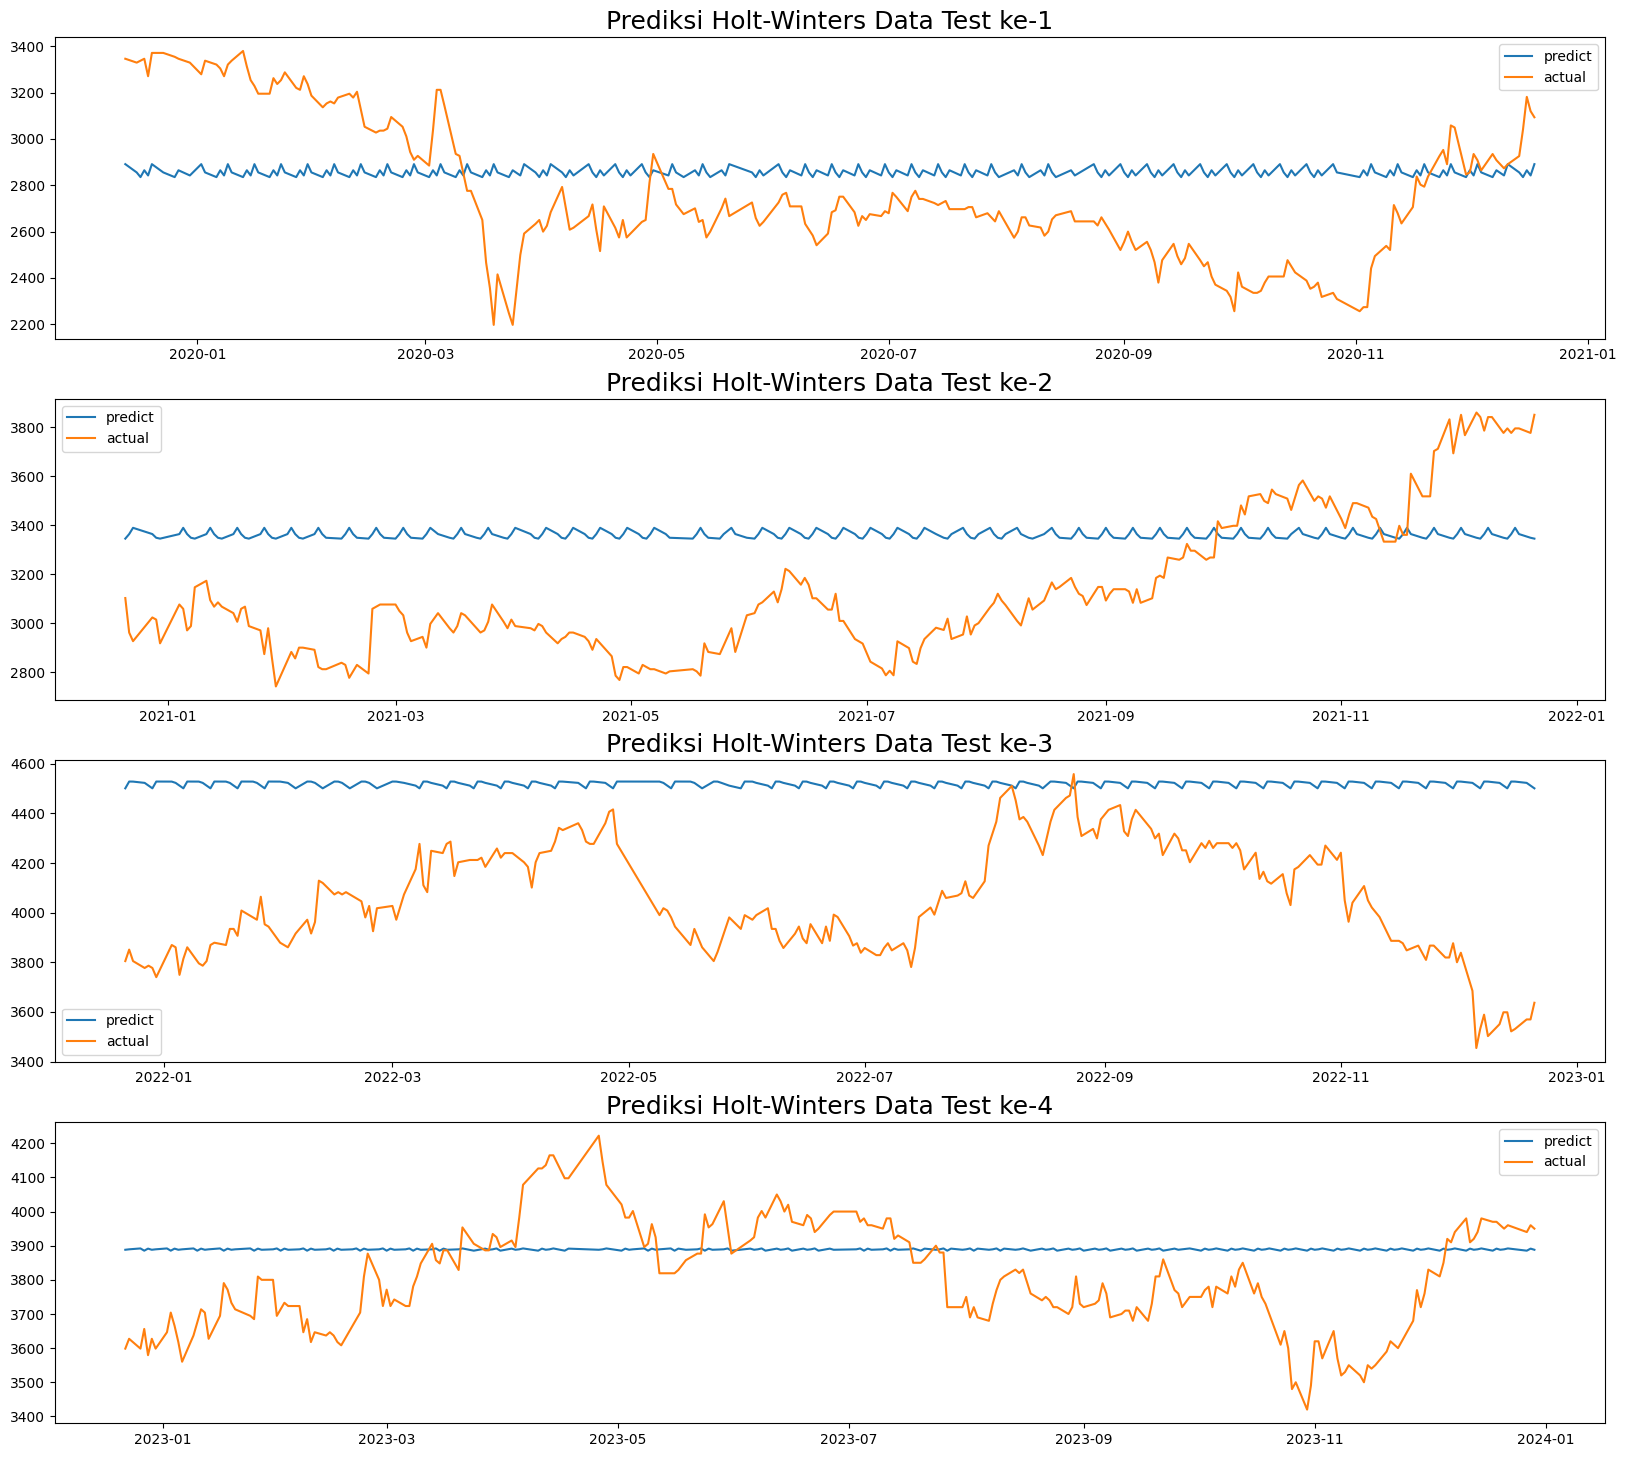

In [ ]:
#Plot Predict Test

fig, axs = plt.subplots(nrows = 4,
                        ncols = 1,
                        figsize = (20, 18))

for i, forec_test in enumerate(forecast_test):
  axs[i].plot(forec_test['predict'], label = 'predict')
  axs[i].plot(forec_test['actual'], label = 'actual')
  axs[i].set_title(f"Prediksi Holt-Winters Data Test ke-{i+1}",
                   fontsize = 18)
  axs[i].legend()

## Evaluation

In [ ]:
# Menghitung MAE, MAPE, dan RMSE
eval_list = []
temp_zip = zip(forecast_train, forecast_test, forecast_data)
for i, (train, test, data) in enumerate(temp_zip):

  eval_dict = {}
  train_mae   = round(mean_absolute_error(train.actual, train['predict']), 3)
  train_mape   = round(mean_absolute_percentage_error(train.actual, train['predict']), 3)
  train_rmse   = round(mean_squared_error(train.actual, train['predict']), 3)

  eval_dict.update({'Latih' : [train_mae, train_mape, train_rmse]})

  test_mae   = round(mean_absolute_error(test.actual, test['predict']), 3)
  test_mape   = round(mean_absolute_percentage_error(test.actual, test['predict']), 3)
  test_rmse   = round(mean_squared_error(test.actual, test['predict']), 3)

  eval_dict.update({'Test' : [test_mae, test_mape, test_rmse]})

  data_mae   = round(mean_absolute_error(data.actual, data['predict']), 3)
  data_mape   = round(mean_absolute_percentage_error(data.actual, data['predict']), 3)
  data_rmse   = round(mean_squared_error(data.actual, data['predict']), 3)

  eval_dict.update({'Data' : [data_mae, data_mape, data_rmse]})

  temp_df_eval = pd.DataFrame(eval_dict, index = ['MAE', 'MAPE', 'RMSE'])
  eval_list.append(temp_df_eval)

print(len(eval_list))

avg_eval = pd.concat(eval_list).groupby(level=0).mean()
print(avg_eval)

4
           Latih          Test         Data
MAE     60.09475     301.74375    138.39650
MAPE     0.01950       0.09100      0.04425
RMSE  6575.52950  130551.31575  45491.78150


In [ ]:
eval_list

[         Latih       Test       Data
 MAE     52.559    270.392    161.035
 MAPE     0.016      0.100      0.058
 RMSE  4416.400  96474.279  50258.987,
          Latih        Test       Data
 MAE     62.779     328.324    151.054
 MAPE     0.021       0.108      0.050
 RMSE  7530.033  130925.684  48550.749,
          Latih        Test       Data
 MAE     61.655     462.506    161.665
 MAPE     0.021       0.117      0.045
 RMSE  7026.334  264020.714  71144.607,
          Latih       Test       Data
 MAE     63.386    145.753     79.832
 MAPE     0.020      0.039      0.024
 RMSE  7329.351  30784.586  12012.783]

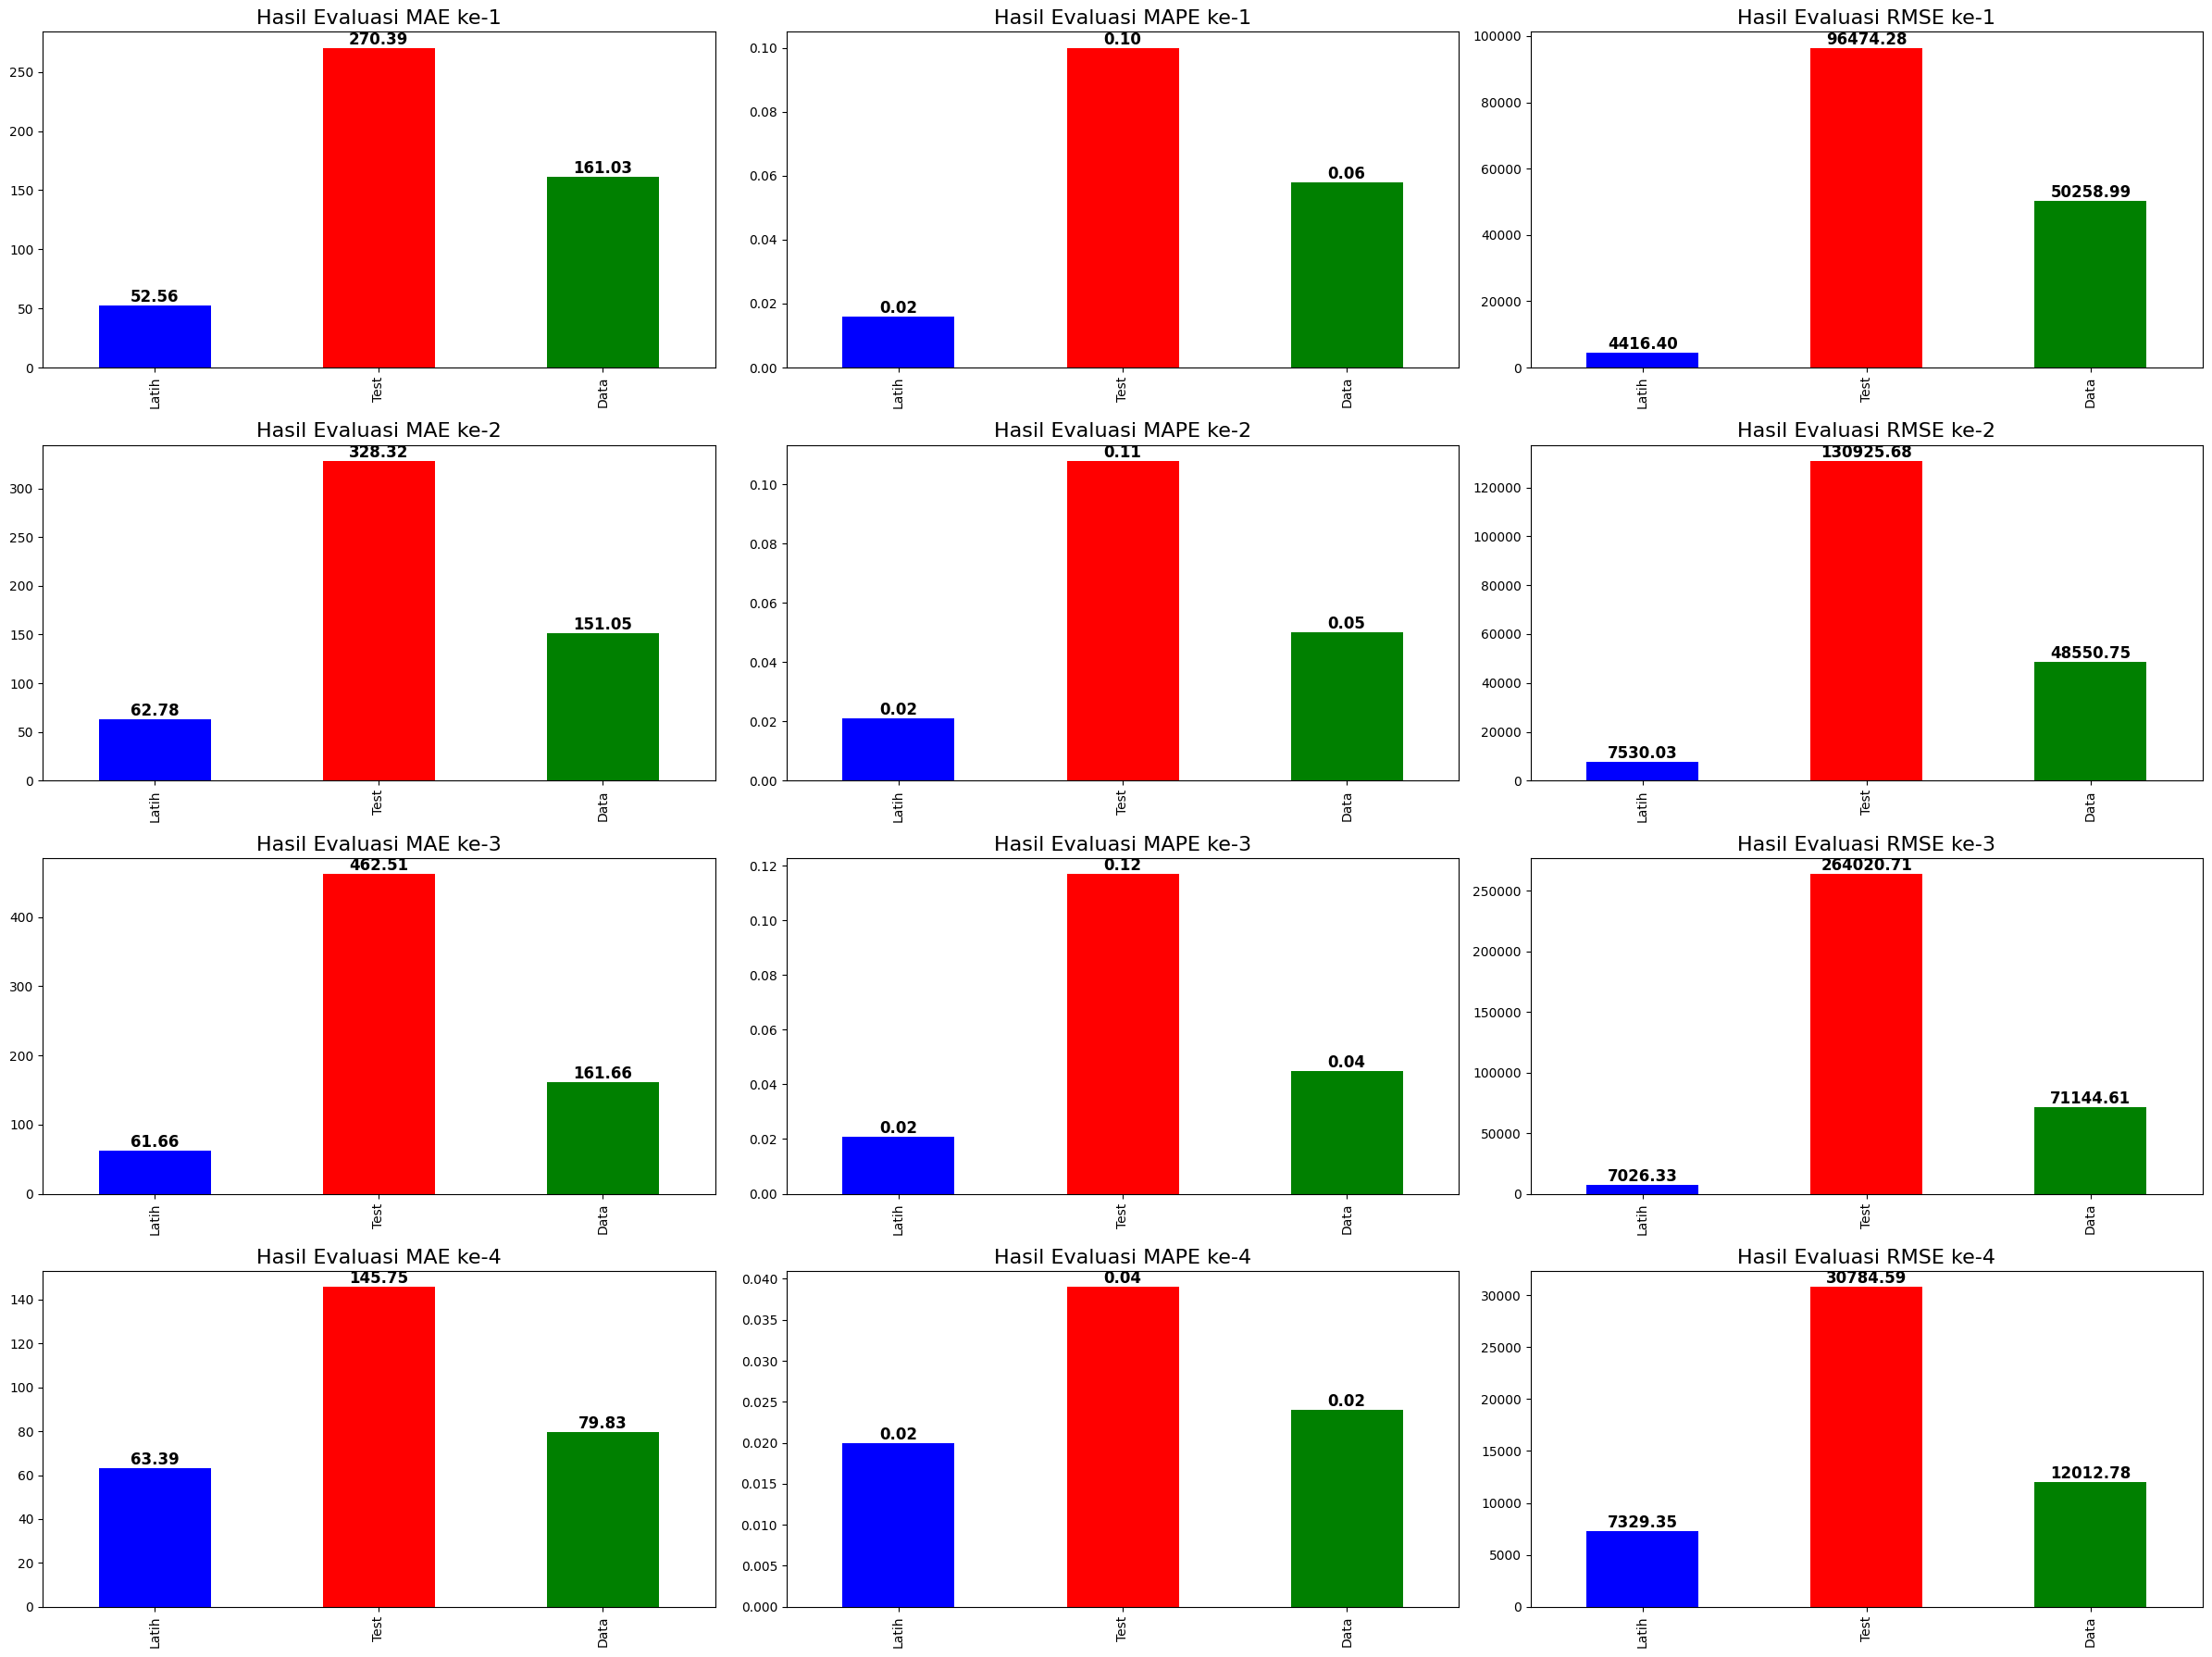

In [ ]:
import matplotlib.pyplot as plt

cols = 3
fig, axs = plt.subplots(nrows=len(eval_list),
                        ncols=cols,
                        figsize=(24, 18))  # Mengatur aspek rasio 4:3

for i, df_eval in enumerate(eval_list):
    df_eval = df_eval.T

    ax1 = df_eval.MAE.plot(kind='bar', ax=axs[i, 0], color=['b', 'r', 'g'])
    axs[i, 0].set_title(f'Hasil Evaluasi MAE ke-{i+1}', fontsize=16)

    ax2 = df_eval.MAPE.plot(kind='bar', ax=axs[i, 1], color=['b', 'r', 'g'])
    axs[i, 1].set_title(f'Hasil Evaluasi MAPE ke-{i+1}', fontsize=16)

    ax3 = df_eval.RMSE.plot(kind='bar', ax=axs[i, 2], color=['b', 'r', 'g'])
    axs[i, 2].set_title(f'Hasil Evaluasi RMSE ke-{i+1}', fontsize=16)

    # Tambahkan nilai ticks di atas setiap bar
    for ax in [ax1, ax2, ax3]:
        for bar in ax.patches:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


# ANN

## Preprocessing Data

### Residual and Plot Data



In [ ]:
resid_train, resid_test, resid_data = [], [], []
zipped = zip(forecast_train, forecast_test, forecast_data)

for forec_train, forec_test, forec_data in zipped:

  # data residu
  residual_es_data = forec_data['actual'] - forec_data['predict']
  df_residual_es_data = pd.DataFrame(residual_es_data)

  resid_data.append(df_residual_es_data)

  # train residu
  residual_es_train = forec_train['actual'] - forec_train['predict']
  df_residual_es_train = pd.DataFrame(residual_es_train)

  resid_train.append(df_residual_es_train)

  # test residu
  residual_es_test = forec_test['actual'] - forec_test['predict']
  df_residual_es_test = pd.DataFrame(residual_es_test)

  resid_test.append(df_residual_es_test)

In [ ]:
for i in range(1,5):
  resid_train[i-1].to_excel(f'Residu Data Train {i}.xlsx')
  resid_test[i-1].to_excel(f'Residu Data Test {i}.xlsx')

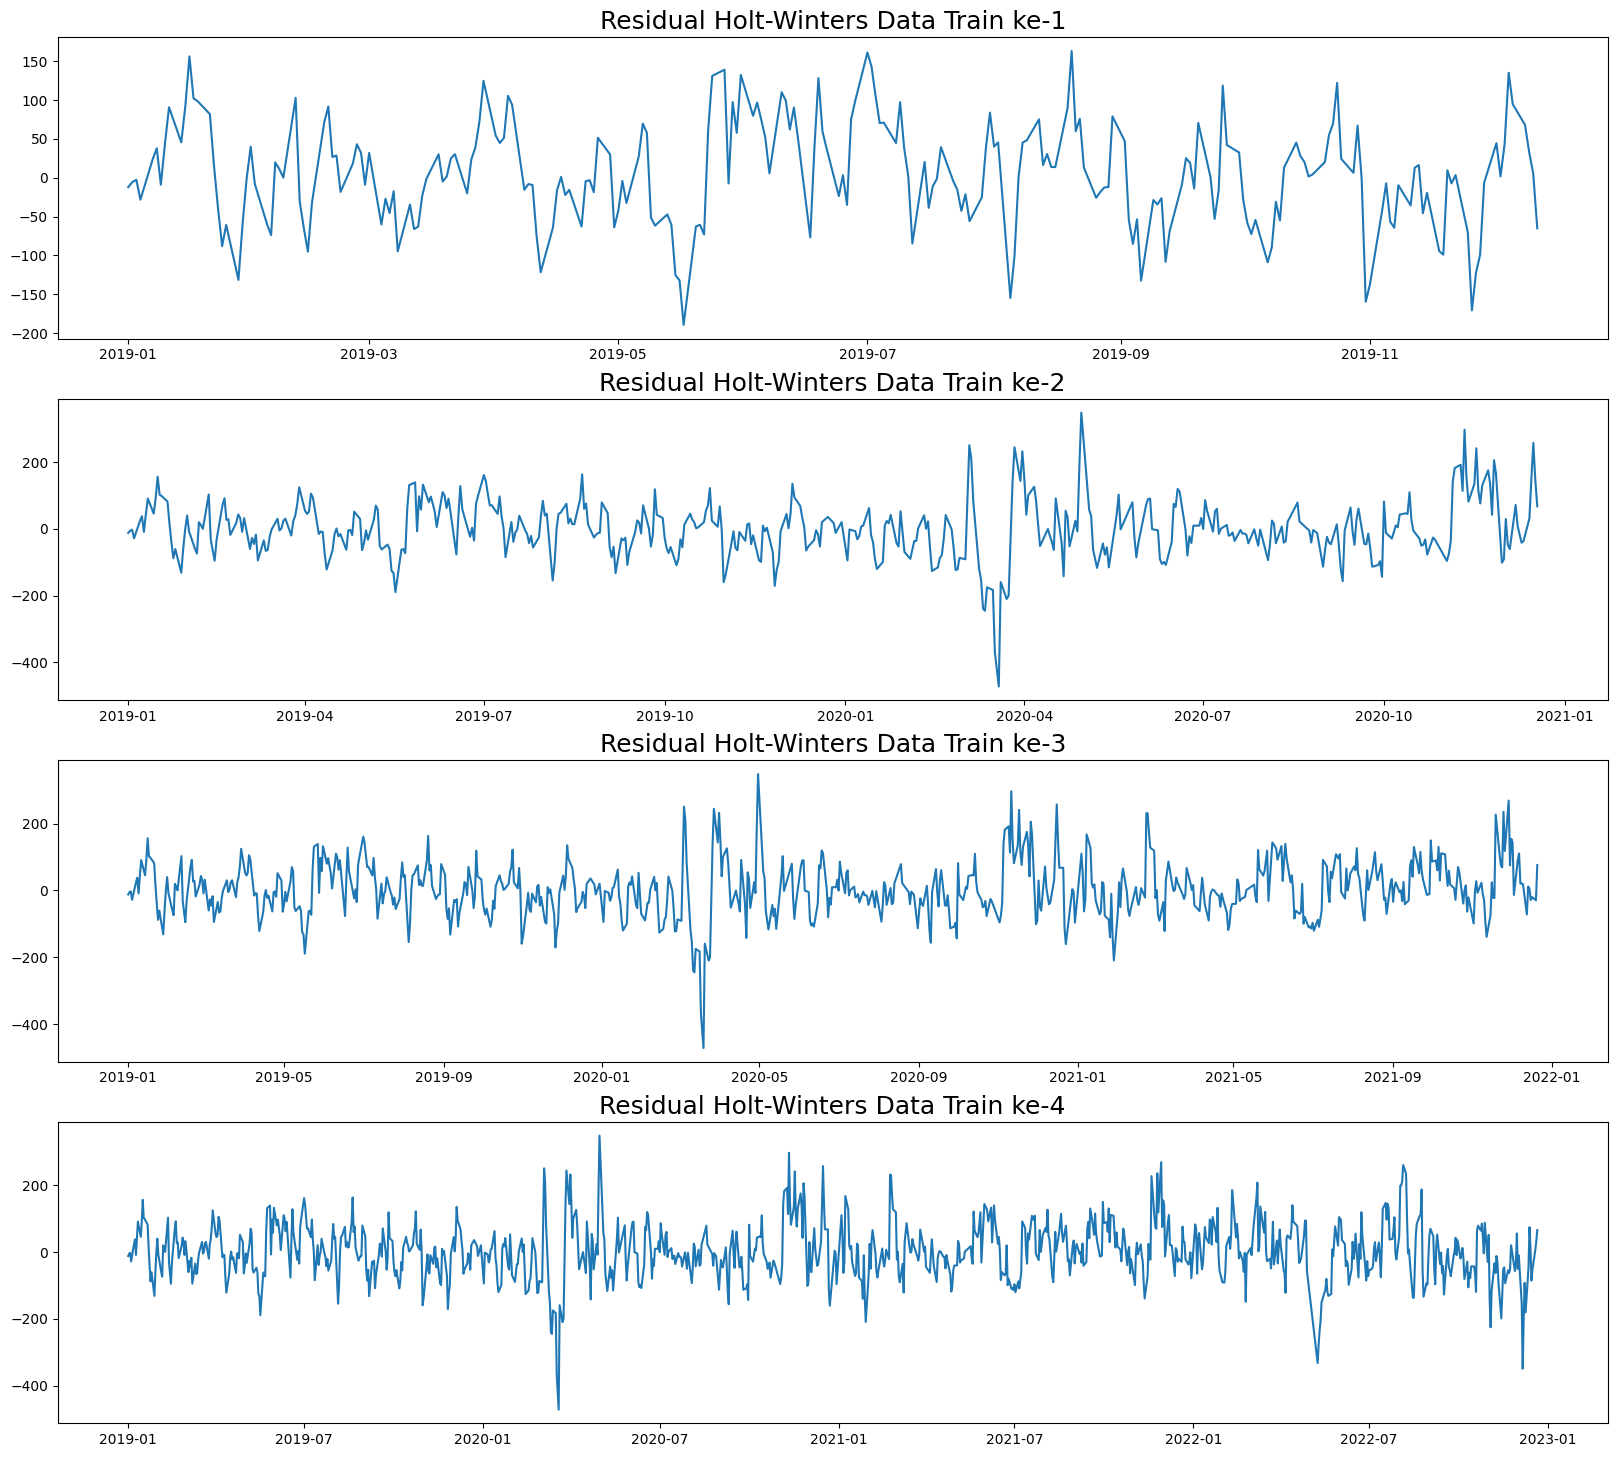

In [ ]:
# Plot Residual Train

fig, axs = plt.subplots(nrows = 4,
                        ncols = 1,
                        figsize = (20, 18))

for i, residual_forec_train in enumerate(resid_train):
  axs[i].plot(residual_forec_train),
  axs[i].set_title(f"Residual Holt-Winters Data Train ke-{i+1}",
                   fontsize = 18)

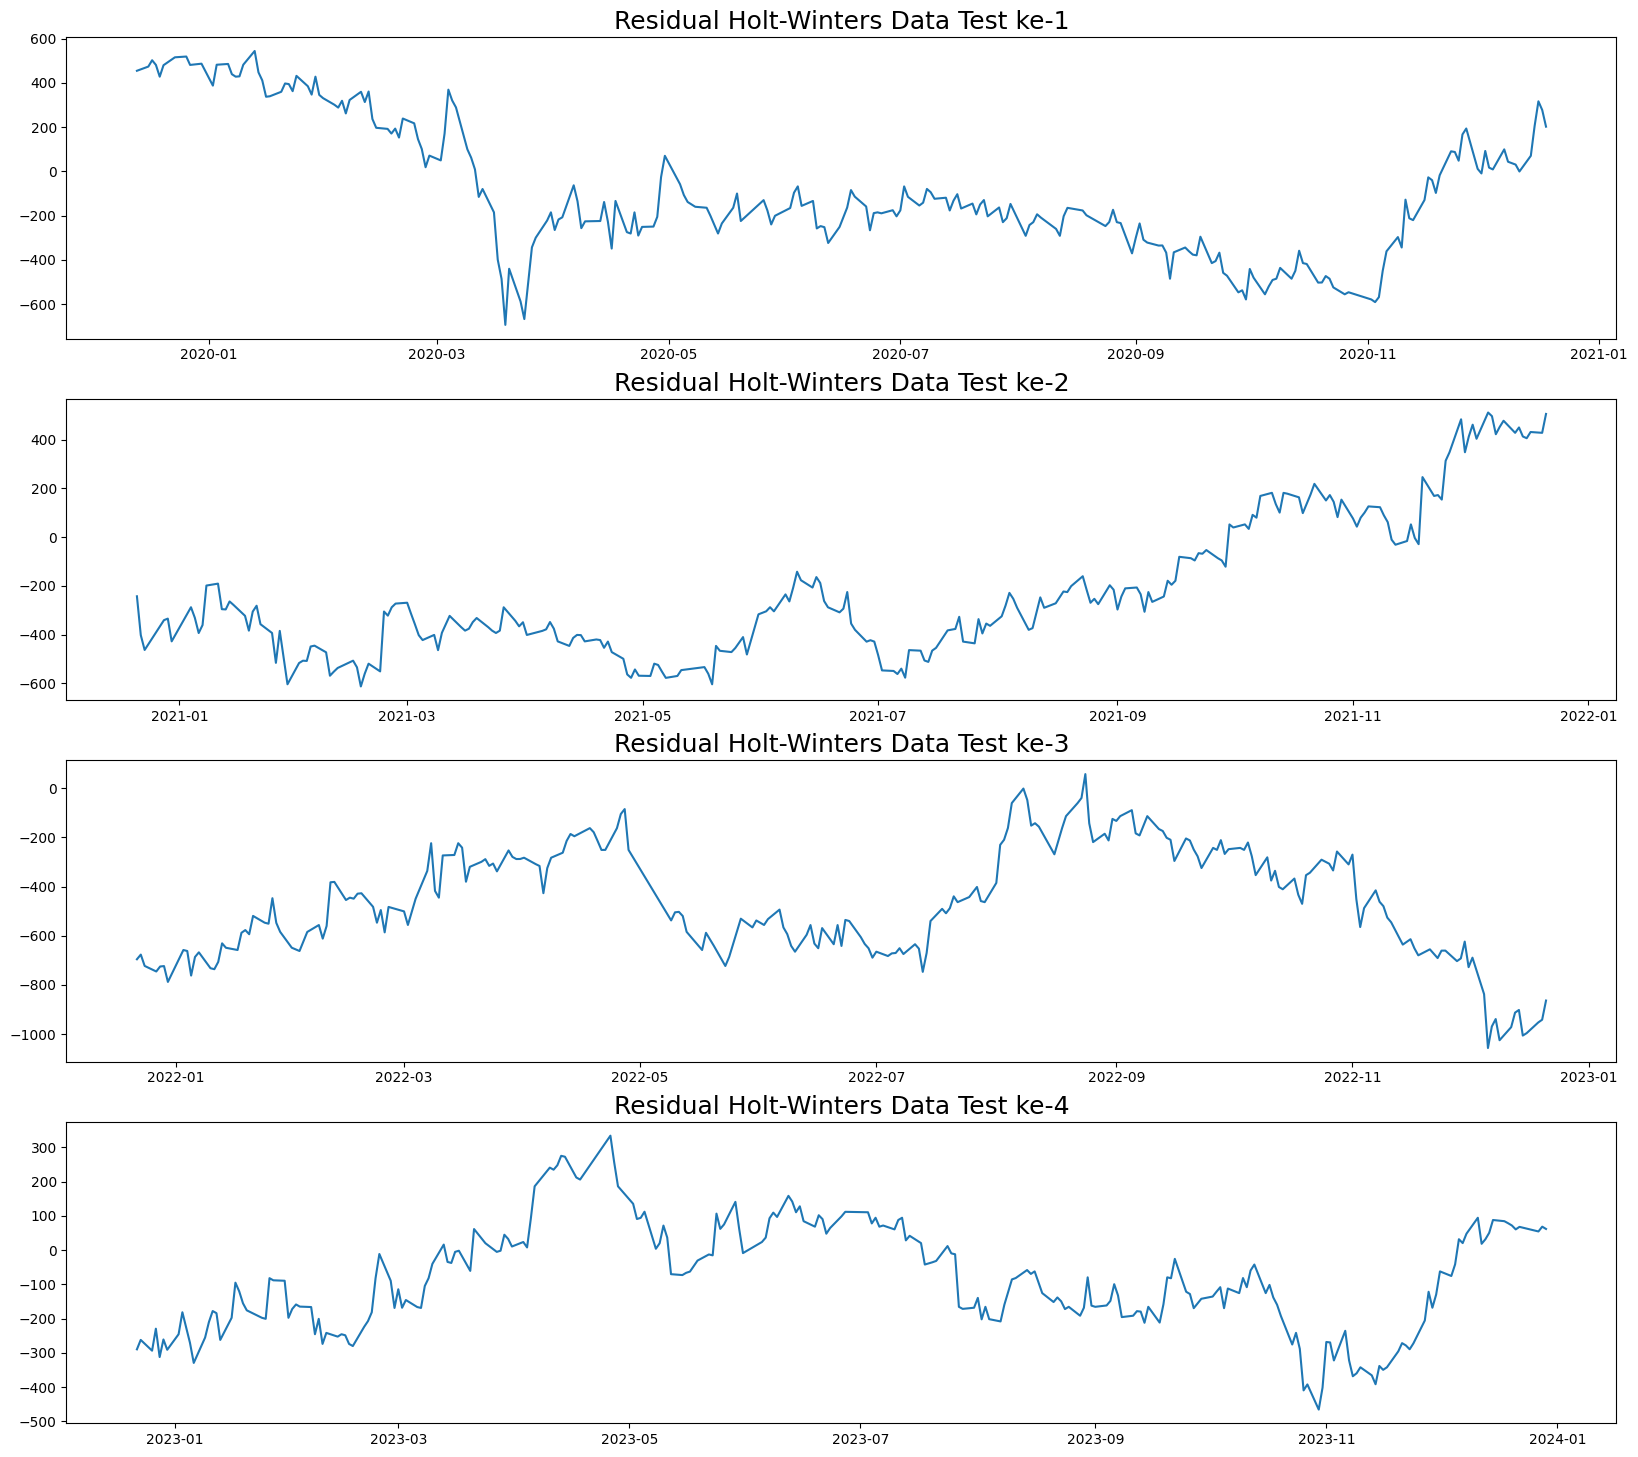

In [ ]:
# Plot test

fig, axs = plt.subplots(nrows = 4,
                        ncols = 1,
                        figsize = (20, 18))

for i, residual_forec_test in enumerate(resid_test):
  axs[i].plot(residual_forec_test),
  axs[i].set_title(f"Residual Holt-Winters Data Test ke-{i+1}",
                   fontsize = 18)

In [ ]:
# Mengambil index data keseluruhan pada 4 iterasi
index_list = []
for i, j in enumerate(df):
  j = j.index
  index_name = f'index{i+1}'
  locals()[index_name] = j
  index_list.append(locals()[index_name])

# Mengambil index data latih pada 4 iterasi
train_index_list = []
for i in data[0:4]:
  for j, k in enumerate(i):
    if (j+1)%2 != 0:
      k = k.index
      train_index_name = f'train_index{j+1}'
      locals()[train_index_name] = k
      train_index_list.append(locals()[train_index_name])

# Mengambil index data uji pada 4 iterasi
test_index_list = []
for i in data[0:4]:
  for j, k in enumerate(i):
    if (j+1)%2 == 0:
      k = k.index
      test_index_name = f'test_index{j+1}'
      locals()[test_index_name] = k
      test_index_list.append(locals()[test_index_name])

### Data Normalize

In [ ]:
resid_train[0]

0
Date                 
2019-01-01 -12.172680
2019-01-02  -5.719315
2019-01-03  -2.641866
2019-01-04 -28.290296
2019-01-07  23.769162
...               ...
2019-12-06  94.518936
2019-12-09  68.039135
2019-12-10  33.348407
2019-12-11   5.633421
2019-12-12 -65.036939

[248 rows x 1 columns]

In [ ]:
zipped = zip(resid_train, resid_test, resid_data)

resid_train_scaler, resid_test_scaler, resid_train_scaled, resid_test_scaled, resid_data_scaler, resid_data_scaled= [], [], [], [], [], []

for es_resid_train, es_resid_test, es_resid_data in zipped:

  # Train Scaling
  temp_scaler_resid_train = MinMaxScaler(feature_range = (0, 1))
  temp_scaled_resid_train = temp_scaler_resid_train.fit_transform(es_resid_train)
  df_temp_scaled_resid_train = pd.DataFrame(temp_scaled_resid_train)

  df_temp_scaled_resid_train.set_index(es_resid_train.index, inplace = True)
  df_temp_scaled_resid_train.rename(columns = {0:'Price'}, inplace = True)

  resid_train_scaler.append(temp_scaler_resid_train)
  resid_train_scaled.append(df_temp_scaled_resid_train)

  # Test Scaling
  temp_scaler_resid_test = MinMaxScaler(feature_range = (0, 1))
  temp_scaled_resid_test = temp_scaler_resid_test.fit_transform(es_resid_test)
  df_temp_scaled_resid_test = pd.DataFrame(temp_scaled_resid_test)

  df_temp_scaled_resid_test.set_index(es_resid_test.index, inplace = True)
  df_temp_scaled_resid_test.rename(columns = {0:'Price'}, inplace = True)

  resid_test_scaler.append(temp_scaler_resid_test)
  resid_test_scaled.append(df_temp_scaled_resid_test)

  # Data Scaling
  temp_scaler_resid_data = MinMaxScaler(feature_range = (0, 1))
  temp_scaled_resid_data = temp_scaler_resid_data.fit_transform(es_resid_data)
  df_temp_scaled_resid_data = pd.DataFrame(temp_scaled_resid_data)

  df_temp_scaled_resid_data.set_index(es_resid_data.index, inplace = True)
  df_temp_scaled_resid_data.rename(columns = {0:'Price'}, inplace = True)

  resid_data_scaler.append(temp_scaler_resid_data)
  resid_data_scaled.append(df_temp_scaled_resid_data)

In [ ]:
resid_train_scaled[0]

Price
Date                
2019-01-01  0.502789
2019-01-02  0.521098
2019-01-03  0.529829
2019-01-04  0.457061
2019-01-07  0.604762
...              ...
2019-12-06  0.805490
2019-12-09  0.730362
2019-12-10  0.631939
2019-12-11  0.553308
2019-12-12  0.352804

[248 rows x 1 columns]

In [ ]:
for i in range(1,5):
  resid_train_scaled[i-1].to_excel(f'Normalisasi Residual Data Train {i}.xlsx')
  resid_test_scaled[i-1].to_excel(f'Normalisasi Residual Data Test {i}.xlsx')

## Forecast

### Sliding Window

In [ ]:
# Build Model
def SlidingWindow(df, lookback):
    X, y = [], []
    for i in range(len(df) - lookback - 1):
        X.append(df.iloc[i:(i + lookback), 0])
        y.append(df.iloc[i + lookback, 0])

    return np.array(X), np.array(y)

In [ ]:
lookback = 3

# Penerapan Sliding Window

set_seed(25)

Xtrain_resid, ytrain_resid, Xtest_resid, ytest_resid, Xdata_resid, ydata_resid = [], [], [], [], [], []

for es_resid_train, es_resid_test, es_resid_data in zip(resid_train_scaled, resid_test_scaled, resid_data_scaled):
    X_train, y_train = SlidingWindow(es_resid_train, lookback)
    Xtrain_resid.append(X_train)
    ytrain_resid.append(y_train)

    X_test, y_test = SlidingWindow(es_resid_test, lookback)
    Xtest_resid.append(X_test)
    ytest_resid.append(y_test)

    X_data, y_data = SlidingWindow(es_resid_data, lookback)
    Xdata_resid.append(X_data)
    ydata_resid.append(y_data)

### Build Model ANN


In [ ]:
# Callback Interpretation

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss',
    min_delta = 0.001,
    verbose = 1,
    patience = 5,
    restore_best_weights = True,
    mode = 'min'
)

# Set Up Optimizer
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [1e-0, 1e-1, 1e-2])
lr = 1e-2 * schedule(step)
wd = lambda: 1e-3 * schedule(step)

optimizer = AdamW(learning_rate=lr, weight_decay=wd)

In [ ]:
start_time = time.time()

set_seed(1000)

# Fitting and Forecasting

zipped = zip(Xtrain_resid, ytrain_resid, Xtest_resid, ytest_resid,
             resid_train_scaler, resid_test_scaler,
             df_train, df_test, # Hanya diambil indeks-nya
             resid_train, resid_test, resid_data)

train_resid_forec, test_resid_forec, data_resid_forec = [], [], []

for Xtrain, ytrain, Xtest, ytest, train_scaler, test_scaler, train, test, res_train, res_test, res_data in zipped:

  # Building Model
  model = Sequential([
  layers.Dense(5,
               input_shape = (lookback,),
               activation = 'relu'),
  layers.Dense(1,
               activation = 'relu')
  ])

  # Compile Model
  model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = ['mse'])

  # Fitting Model
  model.fit(Xtrain,
            ytrain,
            epochs = 100,
            shuffle = False,
            callbacks = [EarlyStop])

  model.evaluate(Xtest,
                 ytest)

  # Forecasting Residual Data Train
  train_resid_forecast = model.predict(Xtrain)
  train_resid_forecast = train_scaler.inverse_transform(train_resid_forecast)

  train_resid_forecast = pd.DataFrame(train_resid_forecast,
                                      index = train.iloc[lookback + 1:].index)

  train_resid_forecast.rename(columns = {0:'predict'}, inplace = True)
  train_resid_forecast['actual'] = res_train.iloc[lookback + 1:].values

  train_resid_forec.append(train_resid_forecast)

  # Forecasting Residual Data Test
  test_resid_forecast = model.predict(Xtest)
  test_resid_forecast = test_scaler.inverse_transform(test_resid_forecast)

  test_resid_forecast = pd.DataFrame(test_resid_forecast,
                                     index = test.iloc[lookback + 1:].index)
  test_resid_forecast.rename(columns = {0:'predict'}, inplace = True)
  test_resid_forecast['actual'] = res_test.iloc[lookback + 1:].values

  test_resid_forec.append(test_resid_forecast)

  # Combine Train and Test Data Forecast
  df_resid_forecast = pd.concat([train_resid_forecast, test_resid_forecast])
  df_resid_forecast.rename(columns = {0:'predict'}, inplace = True)
  df_resid_forecast['actual'] = pd.concat([res_train.iloc[lookback+1:],
                                           res_test.iloc[lookback+1:]]).values

  data_resid_forec.append(df_resid_forecast)

elapsed_time = time.time() - start_time
print('\n\nWaktu yang dibutuhkan: {:.2f} detik'.format(elapsed_time))

In [ ]:
for i in range(1,5):
  train_resid_forec[i-1].to_excel(f'Peramalan BPNN Data Train {i}.xlsx')
  test_resid_forec[i-1].to_excel(f'Peramalan BPNN Data Test {i}.xlsx')

### Plot Residual Forecast

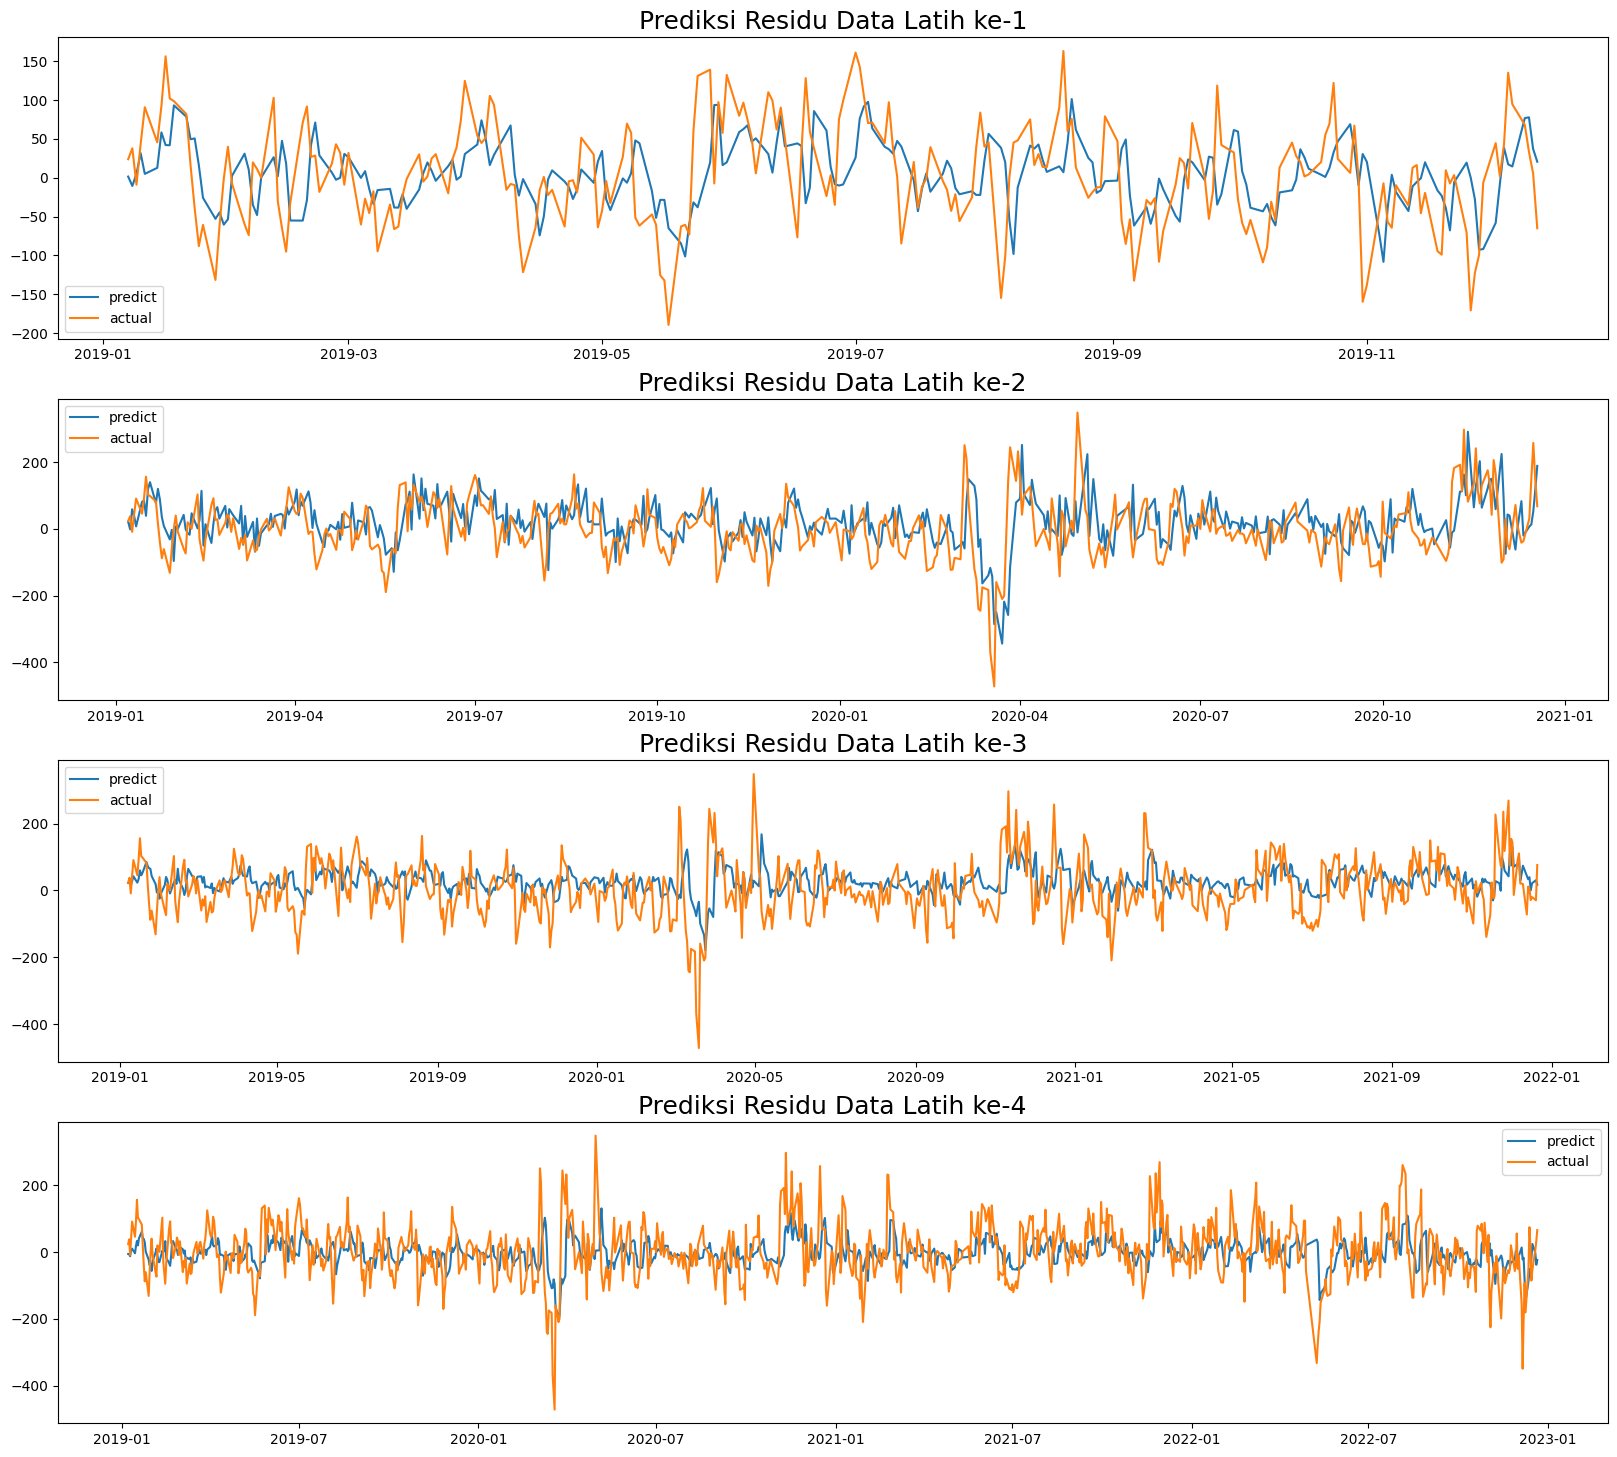

In [ ]:
# Train Residual Plot
fig, axs = plt.subplots(nrows = 4,
                        ncols = 1,
                        figsize = (20, 18))

for i, train in enumerate(train_resid_forec):
  axs[i].plot(train['predict'], label = 'predict')
  axs[i].plot(train['actual'], label = 'actual')
  axs[i].set_title(f"Prediksi Residu Data Latih ke-{i+1}",
                   fontsize = 18)
  axs[i].legend()

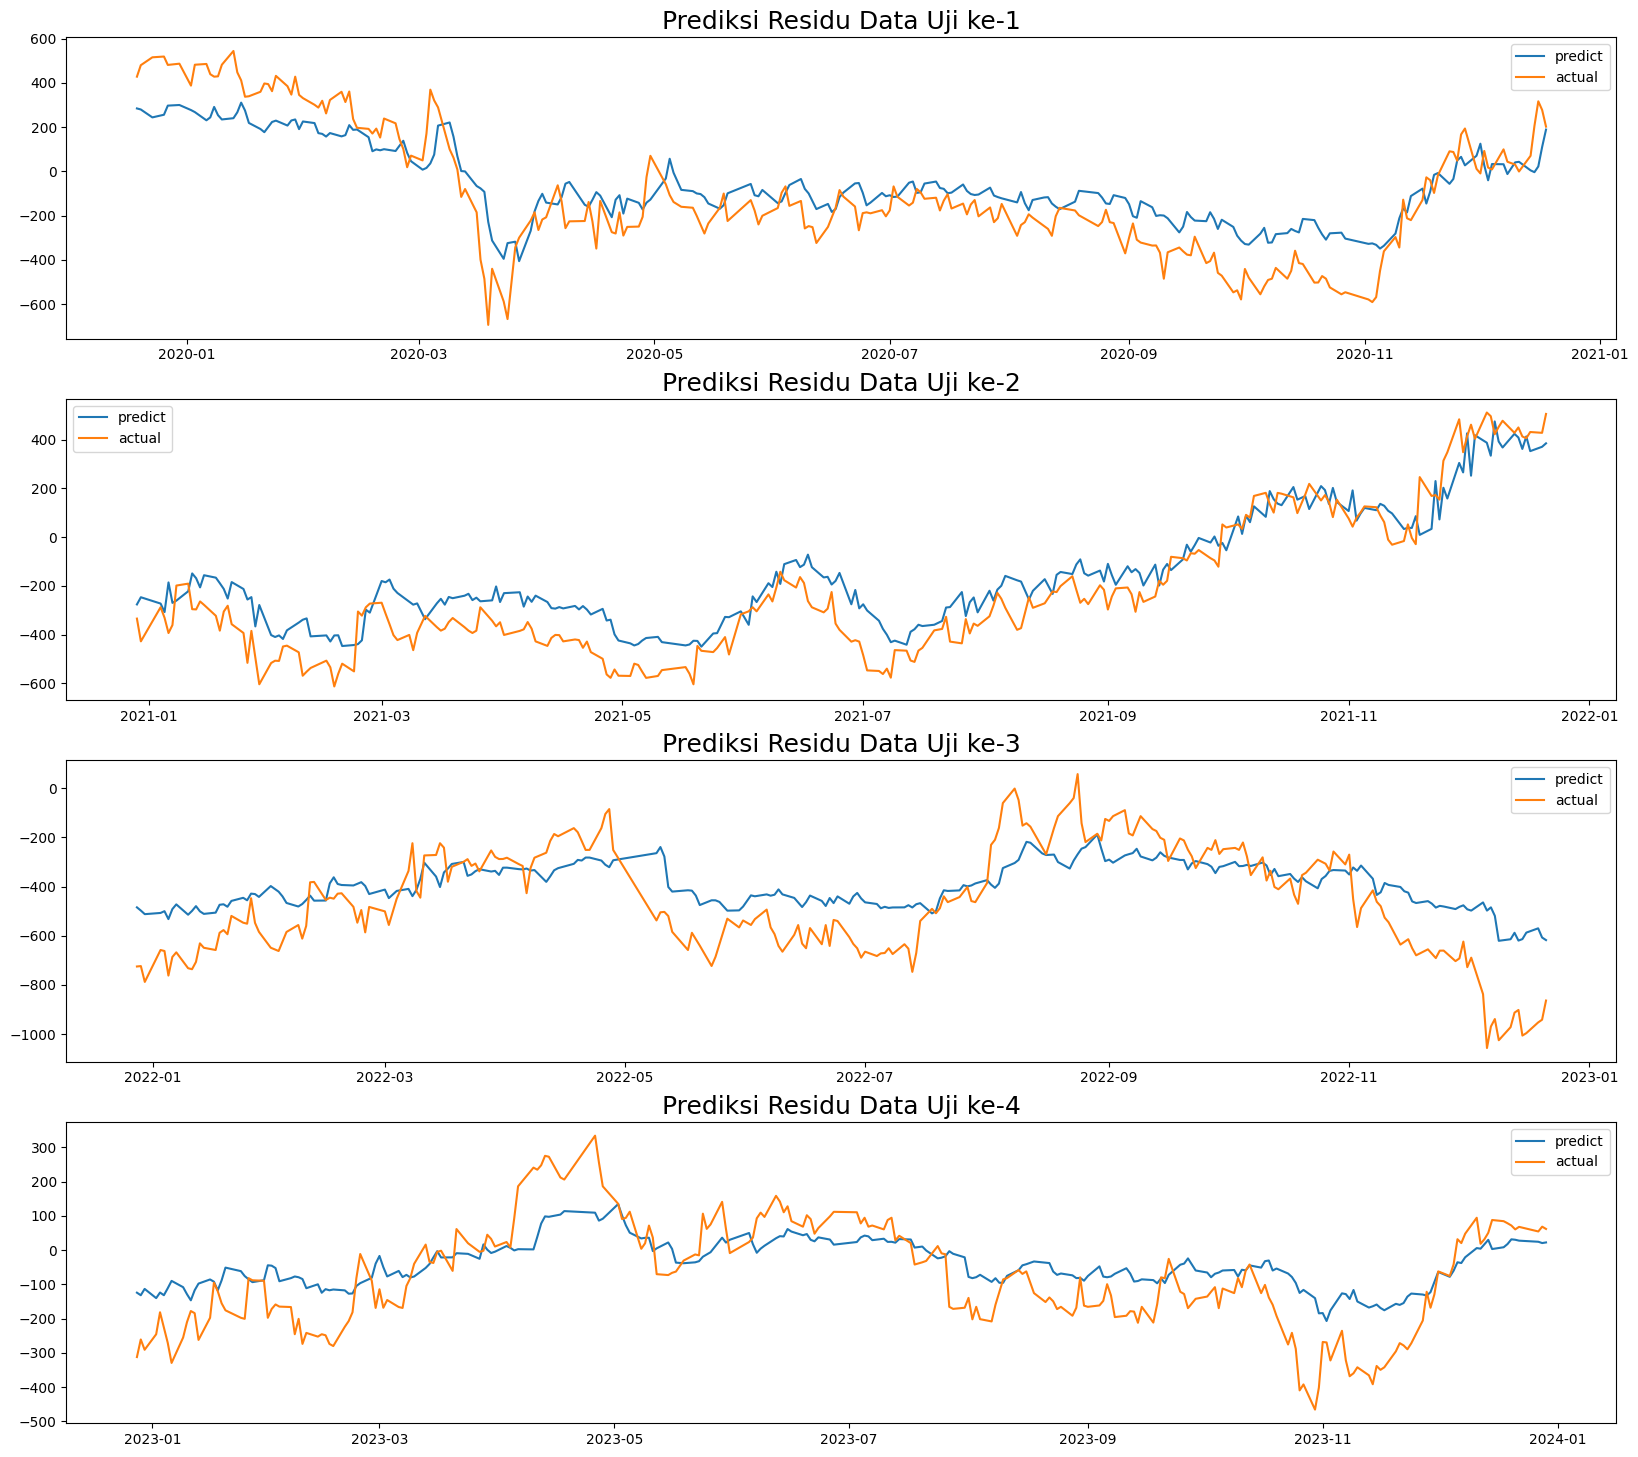

In [ ]:
# Test Residual Plot
fig, axs = plt.subplots(nrows = 4,
                        ncols = 1,
                        figsize = (20, 18))

for i, test in enumerate(test_resid_forec):
  axs[i].plot(test['predict'], label = 'predict')
  axs[i].plot(test['actual'], label = 'actual')
  axs[i].set_title(f"Prediksi Residu Data Uji ke-{i+1}",
                   fontsize = 18)
  axs[i].legend()

### Evaluation Residual

In [ ]:
resid_eval_list = []
temp_zip = zip(train_resid_forec, test_resid_forec, data_resid_forec)
for i, (res_train, res_test, res_data) in enumerate(temp_zip):

  eval_dict = {}
  res_train_mae   = round(mean_absolute_error(res_train.actual, res_train['predict']), 3)
  res_train_mape   = round(mean_absolute_percentage_error(res_train.actual, res_train['predict']), 3)
  res_train_rmse   = round(mean_squared_error(res_train.actual, res_train['predict']), 3)

  eval_dict.update({'Latih' : [res_train_mae, res_train_mape, res_train_rmse]})

  res_test_mae   = round(mean_absolute_error(res_test.actual, res_test['predict']), 3)
  res_test_mape   = round(mean_absolute_percentage_error(res_test.actual, res_test['predict']), 3)
  res_test_rmse   = round(mean_squared_error(res_test.actual, res_test['predict']), 3)

  eval_dict.update({'Uji' : [res_test_mae, res_test_mape, res_test_rmse]})

  res_data_mae   = round(mean_absolute_error(res_data.actual, res_data['predict']), 3)
  res_data_mape   = round(mean_absolute_percentage_error(res_data.actual, res_data['predict']), 3)
  res_data_rmse   = round(mean_squared_error(res_data.actual, res_data['predict']), 3)

  eval_dict.update({'Data' : [res_data_mae, res_data_mape, res_data_rmse]})

  temp_df_eval = pd.DataFrame(eval_dict, index = ['MAE', 'MAPE', 'RMSE'])
  resid_eval_list.append(temp_df_eval)

print(len(resid_eval_list))

4


In [ ]:
resid_eval_list

[         Latih        Uji       Data
 MAE     50.974    124.114     87.394
 MAPE     2.644      1.154      1.902
 RMSE  4301.779  22071.476  13150.064,
          Latih        Uji       Data
 MAE     68.393    100.098     78.875
 MAPE     7.473      0.486      5.163
 RMSE  8136.940  14032.798  10086.117,
          Latih        Uji       Data
 MAE     64.072    133.455     81.240
 MAPE     4.173      1.252      3.451
 RMSE  7232.699  27292.083  12196.269,
          Latih        Uji      Data
 MAE     60.326     83.855    64.978
 MAPE     3.263      0.806     2.777
 RMSE  6636.069  11050.747  7508.905]

# Kombinasi Peramalan

In [ ]:
# Combine Train Forecast
train_comb_forec = []
for hw_train, ann_train, train in zip(forecast_train, train_resid_forec, df_train):
  train_comb = pd.DataFrame(hw_train.iloc[lookback+1:,0].add(ann_train.iloc[:,0]))
  train_comb['actual'] = train.iloc[lookback+1:].values

  train_comb_forec.append(train_comb)

# Combine Test Forecast
test_comb_forec = []
for hw_test, ann_test, test in zip(forecast_test, test_resid_forec, df_test):
  test_comb = pd.DataFrame(hw_test.iloc[lookback+1:,0].add(ann_test.iloc[:,0]))
  test_comb['actual'] = test.iloc[lookback+1:].values

  test_comb_forec.append(test_comb)

# Combine Data Forecast
data_comb_forec = []
for hw_data, ann_data in zip(forecast_data, data_resid_forec):
  data_comb = pd.DataFrame(hw_data.iloc[lookback+1:,0].add(ann_data.iloc[:,0]))
  data_comb.dropna(inplace = True)

  data_comb_forec.append(data_comb)

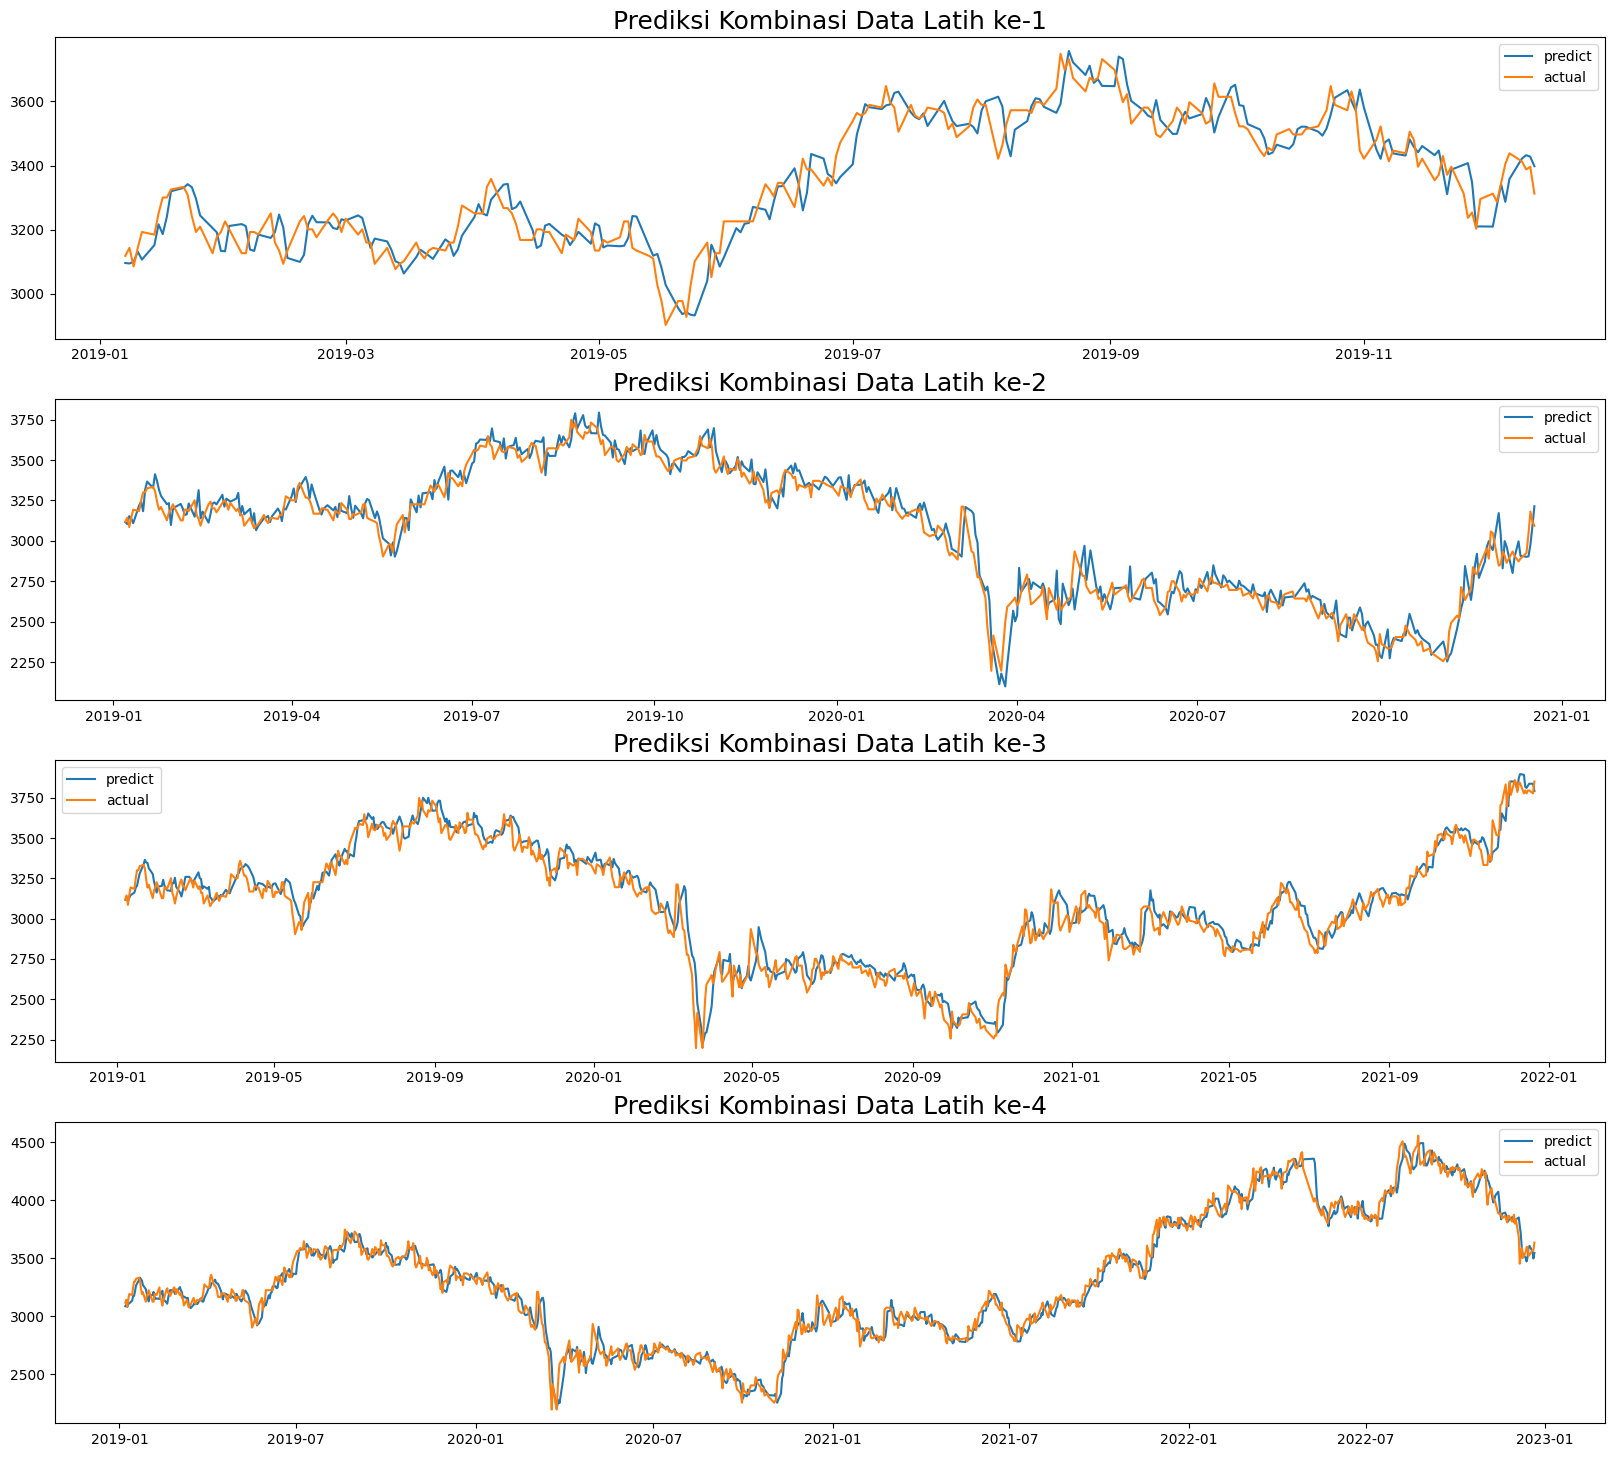

In [ ]:
# Train Combination Plot
fig, axs = plt.subplots(nrows = 4,
                        ncols = 1,
                        figsize = (20, 18))

for i, comb_train in enumerate(train_comb_forec):
  axs[i].plot(comb_train['predict'], label = 'predict')
  axs[i].plot(comb_train['actual'], label = 'actual')
  axs[i].set_title(f"Prediksi Kombinasi Data Latih ke-{i+1}",
                   fontsize = 18)
  axs[i].legend()

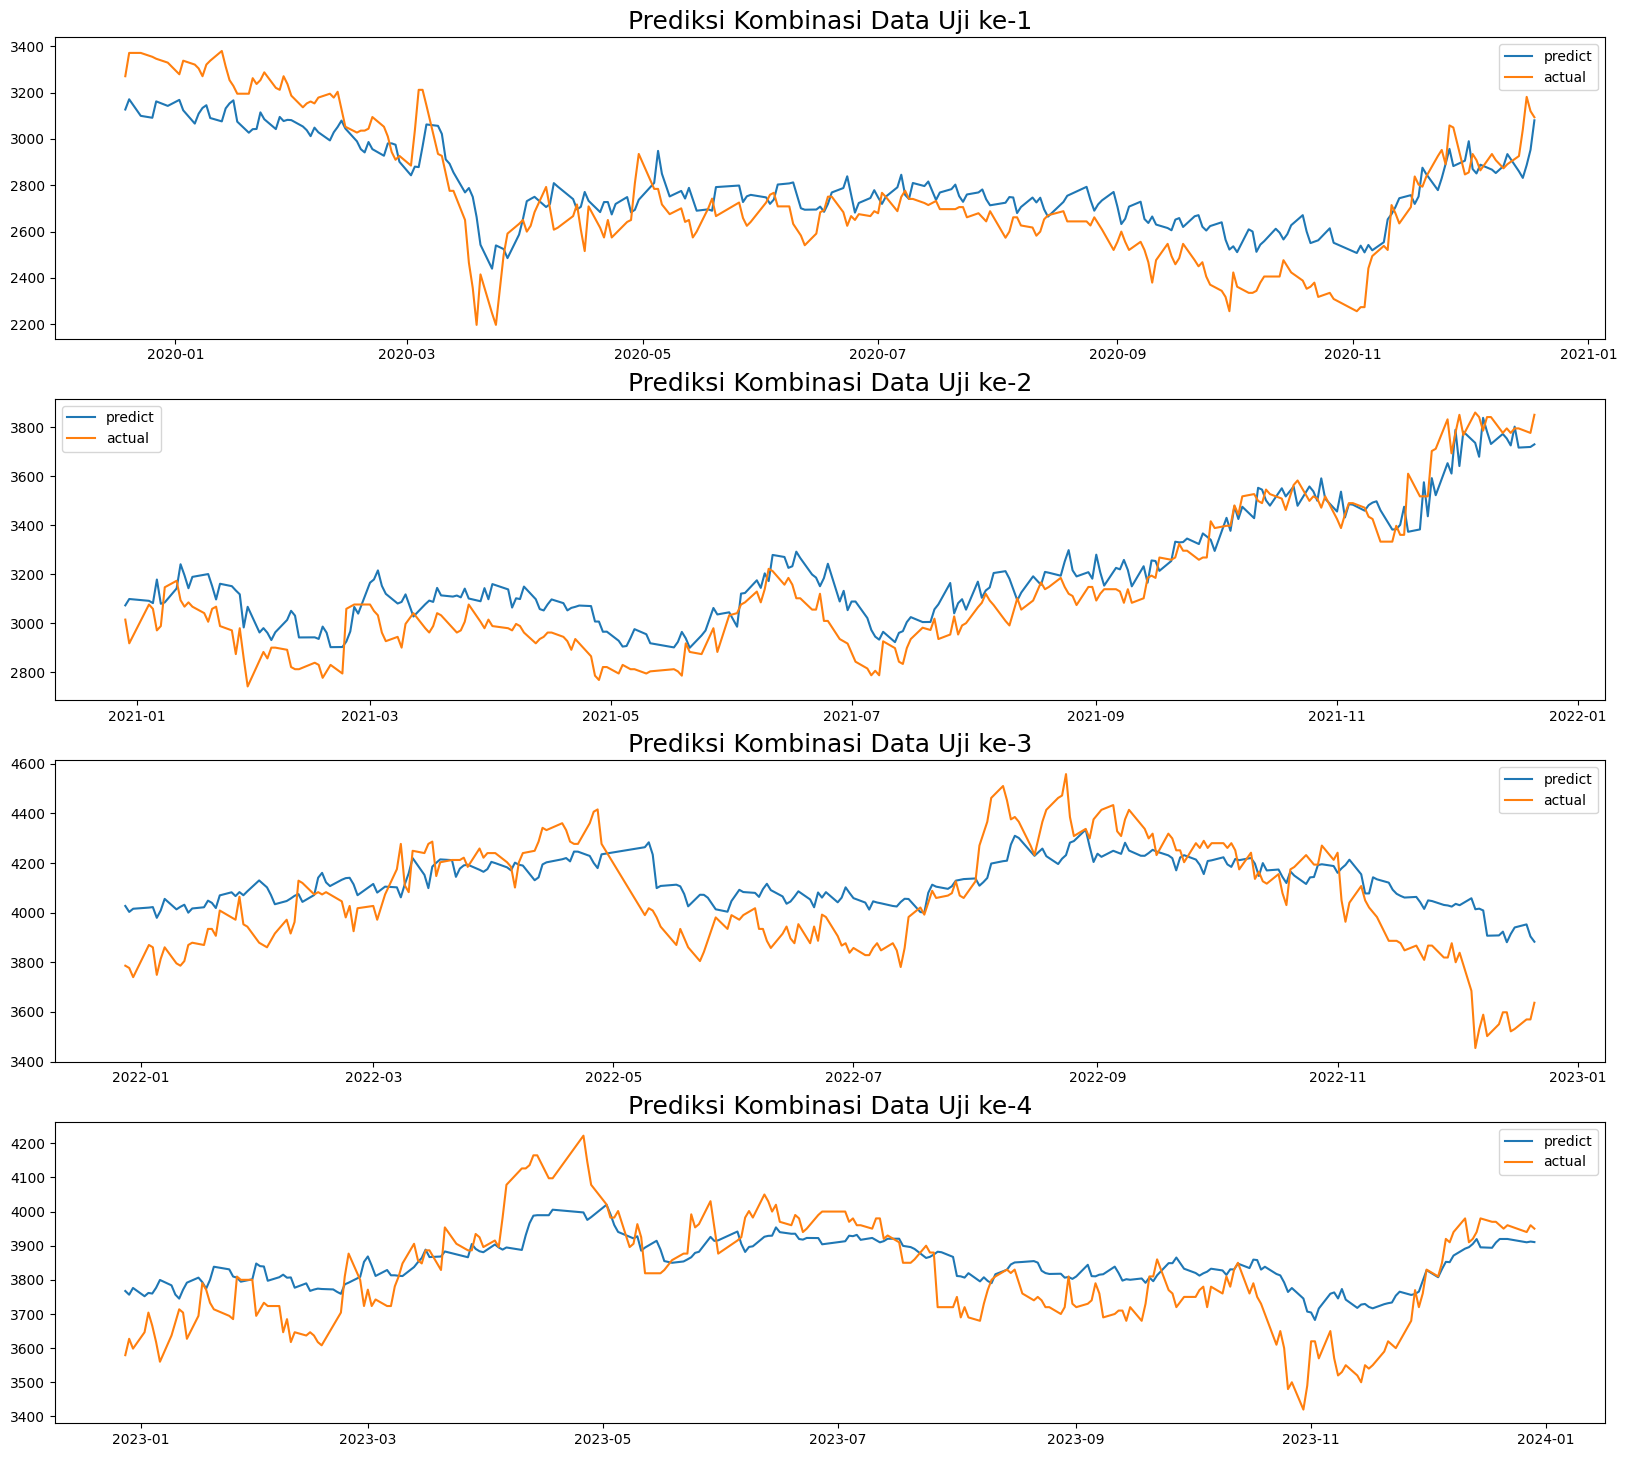

In [ ]:
# Test Combination Plot
fig, axs = plt.subplots(nrows = 4,
                        ncols = 1,
                        figsize = (20, 18))

for i, comb_test in enumerate(test_comb_forec):
  axs[i].plot(comb_test['predict'], label = 'predict')
  axs[i].plot(comb_test['actual'], label = 'actual')
  axs[i].set_title(f"Prediksi Kombinasi Data Uji ke-{i+1}",
                   fontsize = 18)
  axs[i].legend()

In [ ]:
comb_eval_list = []
temp_zip = zip(train_comb_forec, test_comb_forec, data_comb_forec)
for i, (comb_train, comb_test, comb_data) in enumerate(temp_zip):

  eval_dict = {}
  comb_train_mae   = round(mean_absolute_error(comb_train.actual, comb_train['predict']), 3)
  comb_train_mape   = round(mean_absolute_percentage_error(comb_train.actual, comb_train['predict']), 3)
  comb_train_rmse   = round(mean_squared_error(comb_train.actual, comb_train['predict']), 3)

  eval_dict.update({'Latih' : [comb_train_mae, comb_train_mape, comb_train_rmse]})

  comb_test_mae   = round(mean_absolute_error(comb_test.actual, comb_test['predict']), 3)
  comb_test_mape   = round(mean_absolute_percentage_error(comb_test.actual, comb_test['predict']), 3)
  comb_test_rmse   = round(mean_squared_error(comb_test.actual, comb_test['predict']), 3)

  eval_dict.update({'Uji' : [comb_test_mae, comb_test_mape, comb_test_rmse]})

  # comb_data_mae   = round(mean_absolute_error(comb_data.actual, comb_data['predict']), 3)
  # comb_data_mape   = round(mean_absolute_percentage_error(comb_data.actual, comb_data['predict']), 3)
  # comb_data_rmse   = round(mean_squared_error(comb_data.actual, comb_data['predict']), 3)

  # eval_dict.update({'Data' : [comb_data_mae, comb_data_mape, comb_data_rmse]})

  temp_df_eval = pd.DataFrame(eval_dict, index = ['MAE', 'MAPE', 'RMSE'])
  comb_eval_list.append(temp_df_eval)

print(len(comb_eval_list))

avg_eval = pd.concat(comb_eval_list).groupby(level=0).mean()
print(avg_eval)

4
           Latih          Uji
MAE     60.94125    110.38050
MAPE     0.01950      0.03375
RMSE  6576.87175  18611.77600


In [ ]:
comb_eval_list

[         Latih        Uji
 MAE     50.974    124.114
 MAPE     0.015      0.046
 RMSE  4301.779  22071.476,
          Latih        Uji
 MAE     68.393    100.098
 MAPE     0.023      0.033
 RMSE  8136.940  14032.798,
          Latih        Uji
 MAE     64.072    133.455
 MAPE     0.021      0.034
 RMSE  7232.699  27292.083,
          Latih        Uji
 MAE     60.326     83.855
 MAPE     0.019      0.022
 RMSE  6636.069  11050.747]

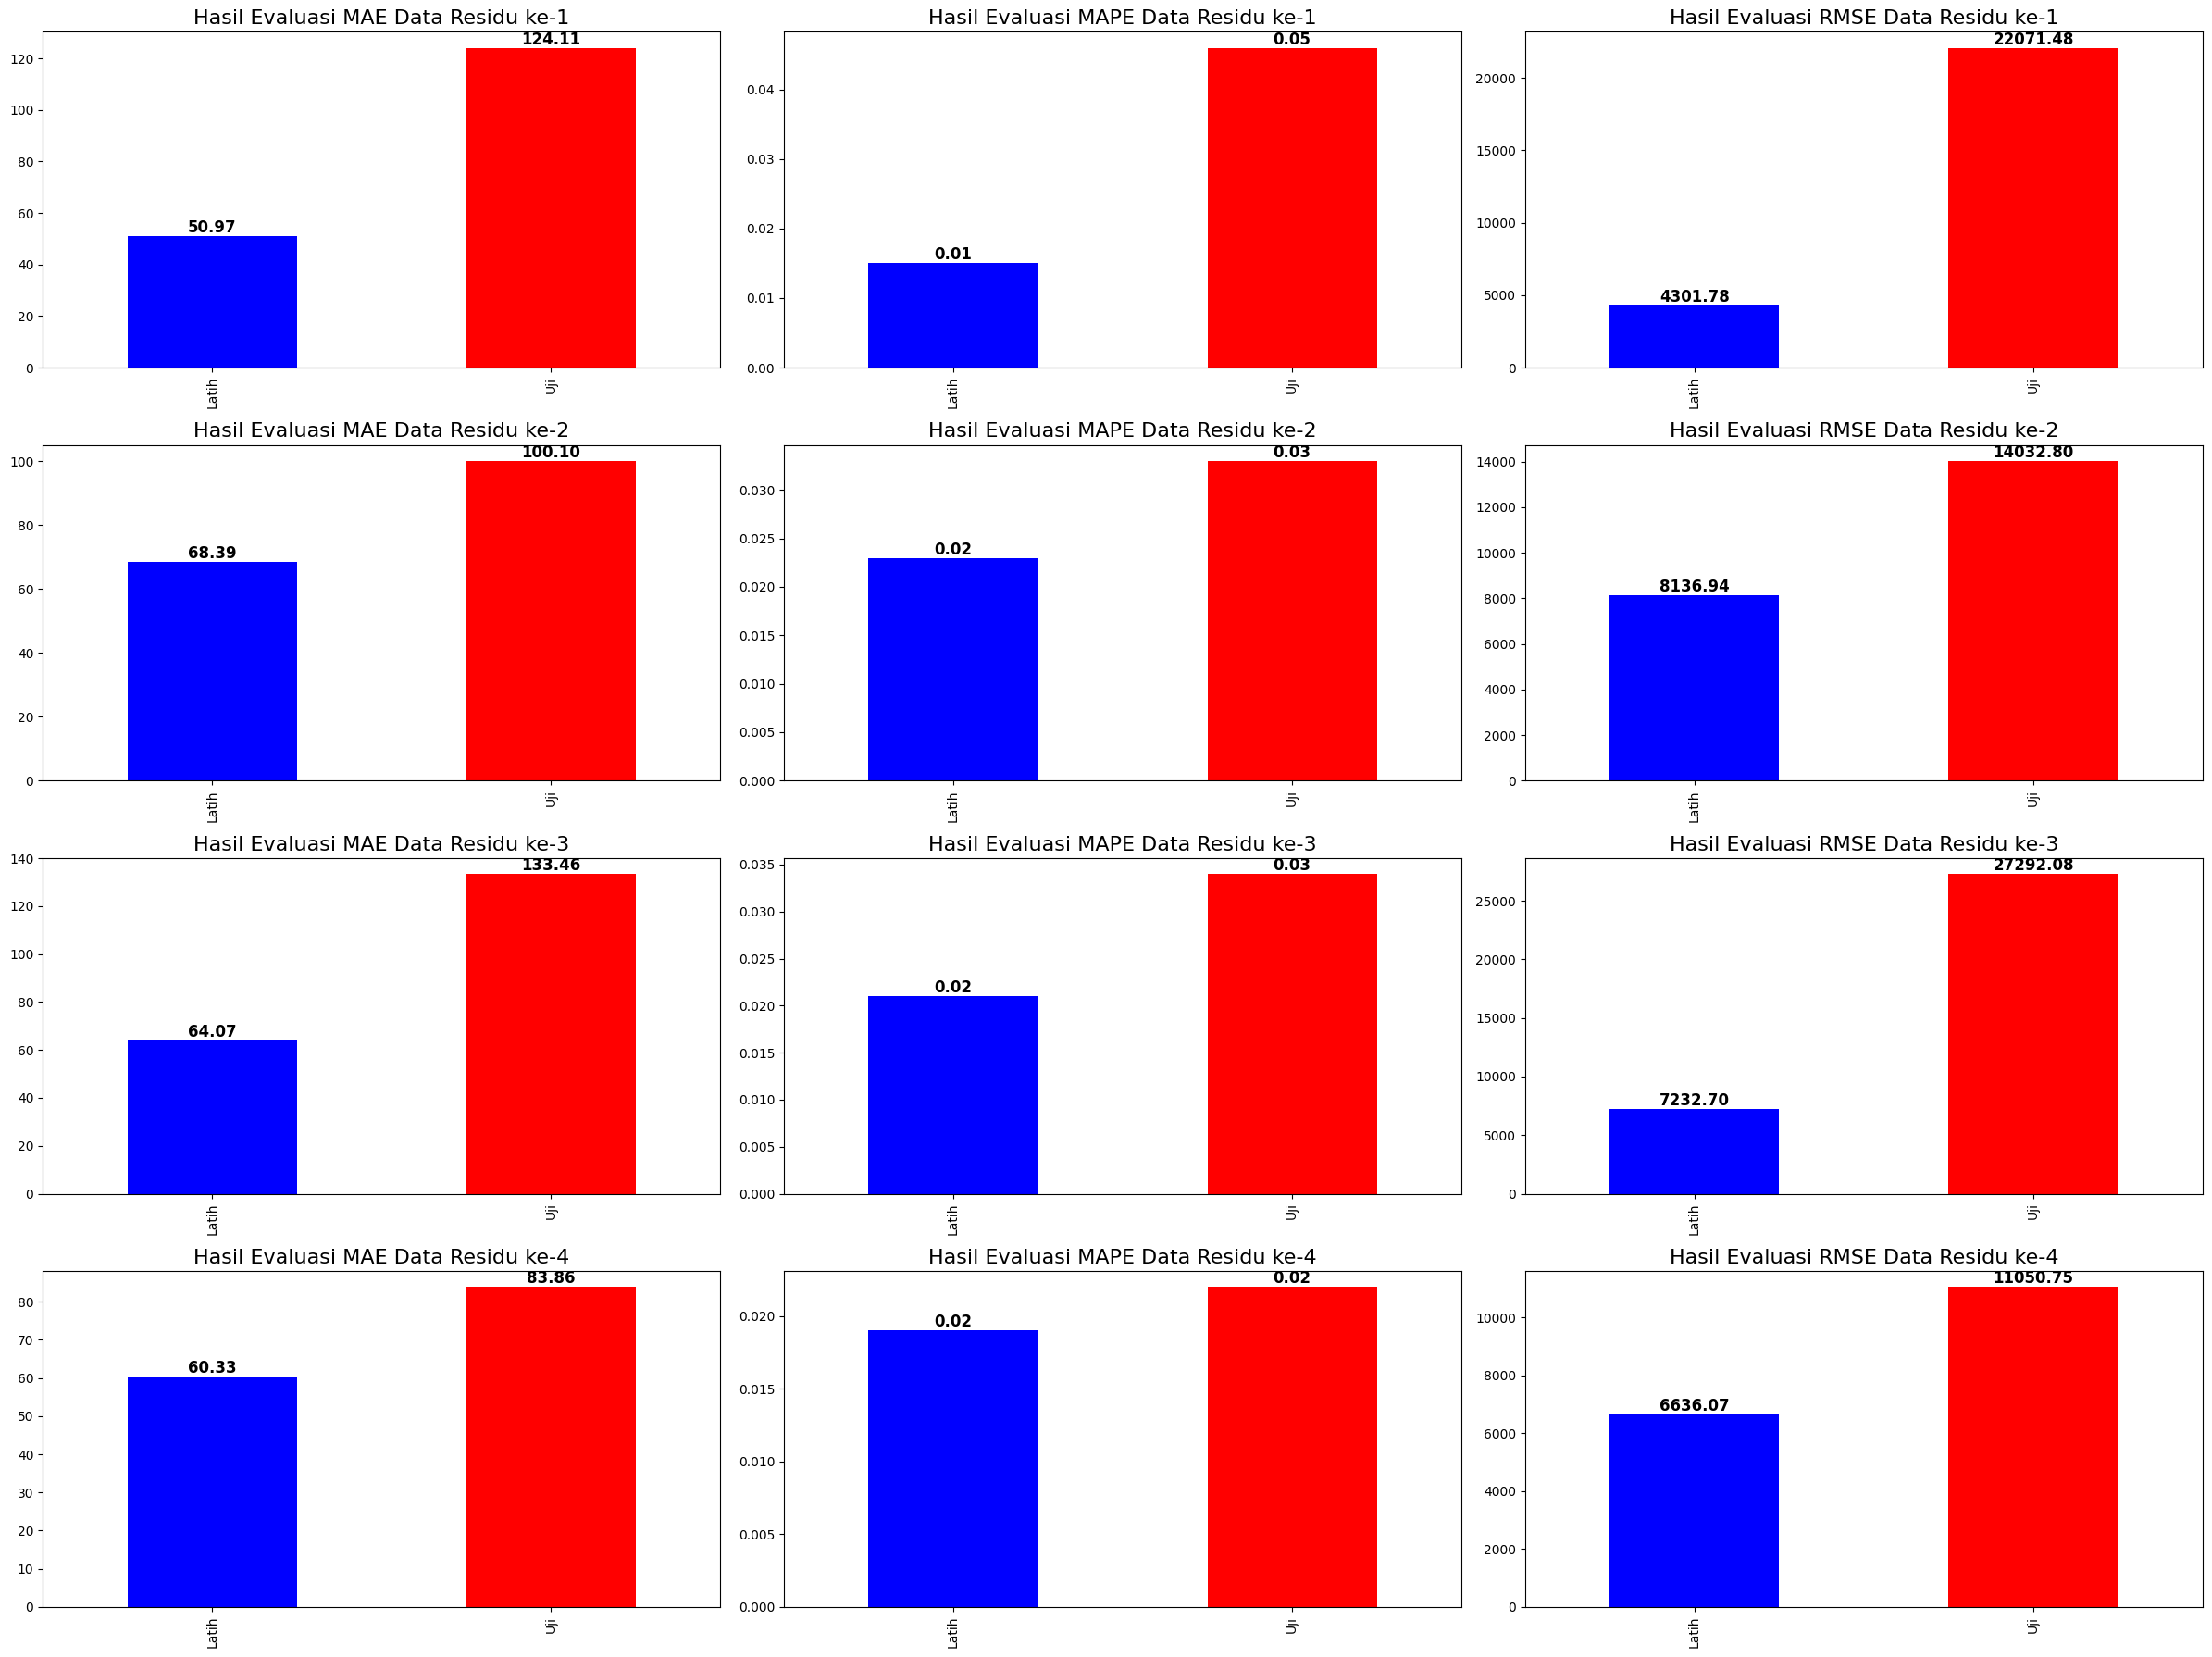

In [ ]:
import matplotlib.pyplot as plt

cols = 3
fig, axs = plt.subplots(nrows=len(comb_eval_list),
                        ncols=cols,
                        figsize=(24, 18))  # Mengatur aspek rasio 4:3

for i, df_eval in enumerate(comb_eval_list):
    df_eval = df_eval.T

    ax1 = df_eval.MAE.plot(kind='bar', ax=axs[i, 0], color=['b', 'r', 'g'])
    axs[i, 0].set_title(f'Hasil Evaluasi MAE Data Residu ke-{i+1}', fontsize=16)

    ax2 = df_eval.MAPE.plot(kind='bar', ax=axs[i, 1], color=['b', 'r', 'g'])
    axs[i, 1].set_title(f'Hasil Evaluasi MAPE Data Residu ke-{i+1}', fontsize=16)

    ax3 = df_eval.RMSE.plot(kind='bar', ax=axs[i, 2], color=['b', 'r', 'g'])
    axs[i, 2].set_title(f'Hasil Evaluasi RMSE Data Residu ke-{i+1}', fontsize=16)

    # Tambahkan nilai ticks di atas setiap bar
    for ax in [ax1, ax2, ax3]:
        for bar in ax.patches:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()